In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops
from sklearn.model_selection import train_test_split                                                                                                   
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
from torch.amp import autocast
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from sklearn.metrics import r2_score as sklearn_r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys
sys.path.append('/home/jovyan/work/GNO/GNN/GNNShap')
from gnnshap.explainer import GNNShapExplainer
import uuid

# 导入Blitz库
from blitz.modules import BayesianLinear                 
from blitz.utils import variational_estimator

# 设备配置
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 自定义数据集类
class HydroDataset(torch.utils.data.Dataset):
    def __init__(self, graphs):
        self.graphs = graphs
    
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self, idx):
        return self.graphs[idx]

class BlitzSTConv(MessagePassing):
    """
    使用Blitz实现的贝叶斯时空卷积层，增强鲁棒性
    """
    def __init__(self, spatial_dim, prior_sigma_1=0.1, prior_sigma_2=0.002, posterior_mu_init=0.0, posterior_rho_init=-3.0, dropout=0.1):
        super().__init__(aggr='mean')
        # 使用标准的PyTorch层进行初始化处理
        self.pre_msg = nn.Linear(2 * spatial_dim + 3, spatial_dim)
        
        # 然后使用Blitz层进行贝叶斯推断
        self.bayes_msg = nn.Sequential(
            BayesianLinear(spatial_dim, spatial_dim,
                        prior_sigma_1=prior_sigma_1, 
                        prior_sigma_2=prior_sigma_2,
                        posterior_mu_init=posterior_mu_init,
                        posterior_rho_init=posterior_rho_init),
            nn.ReLU(inplace=True),
            nn.LayerNorm(spatial_dim),
            nn.Dropout(dropout)
        )
        
        # 同样的模式用于gate网络
        self.pre_gate = nn.Linear(3 * spatial_dim, spatial_dim)
        self.bayes_gate = nn.Sequential(
            BayesianLinear(spatial_dim, spatial_dim,
                        prior_sigma_1=prior_sigma_1, 
                        prior_sigma_2=prior_sigma_2,
                        posterior_mu_init=posterior_mu_init,
                        posterior_rho_init=posterior_rho_init),
            nn.Sigmoid()
        )
        
        # 残差处理
        self.pre_res = nn.Linear(spatial_dim, spatial_dim)
        self.bayes_res = BayesianLinear(spatial_dim, spatial_dim,
                                     prior_sigma_1=prior_sigma_1/2, 
                                     prior_sigma_2=prior_sigma_2/2,
                                     posterior_mu_init=posterior_mu_init,
                                     posterior_rho_init=posterior_rho_init)

    def forward(self, x, edge_index, edge_attr):
        try:
            # 添加调试信息
            # 确保edge_attr是浮点类型
            edge_attr = edge_attr.float()
            
            # 尝试传播消息
            out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
            
            # Gate机制
            combined = torch.cat([x, out, x - out], dim=-1)
            gate_pre = self.pre_gate(combined)
            gate = self.bayes_gate(gate_pre)
            
            # 残差连接
            res_pre = self.pre_res(x)
            res = self.bayes_res(res_pre)
            
            return x + gate * out + 0.1 * res
        except Exception as e:
            print(f"Error in BlitzSTConv.forward: {e}")
            # 提供更详细的错误信息
            print(f"x shape: {x.shape}, dtype: {x.dtype}")
            print(f"edge_index shape: {edge_index.shape}, dtype: {edge_index.dtype}")
            print(f"edge_attr shape: {edge_attr.shape}, dtype: {edge_attr.dtype}")
            raise

    def message(self, x_i, x_j, edge_attr):
        try:
            # 添加调试信息
            edge_attr = edge_attr.to(x_i.dtype).to(x_i.device)
            
            # 先使用标准层，然后使用贝叶斯层
            combined = torch.cat([x_i, x_j, edge_attr], dim=-1)
            pre_msg = self.pre_msg(combined)
            return self.bayes_msg(pre_msg)
        except Exception as e:
            print(f"Error in BlitzSTConv.message: {e}")
            # 提供更详细的错误信息
            print(f"x_i shape: {x_i.shape}, dtype: {x_i.dtype}")
            print(f"x_j shape: {x_j.shape}, dtype: {x_j.dtype}")
            print(f"edge_attr shape: {edge_attr.shape}, dtype: {edge_attr.dtype}")
            raise

class BlitzBoundaryProcessor(nn.Module):
    """
    使用Blitz实现的贝叶斯边界处理器
    """
    def __init__(self, dim, prior_sigma_1=0.1, prior_sigma_2=0.002, posterior_mu_init=0.0, posterior_rho_init=-3.0):
        super().__init__()
        self.boundary_net = nn.Sequential(
            BayesianLinear(dim + 1, dim,
                        prior_sigma_1=prior_sigma_1, 
                        prior_sigma_2=prior_sigma_2,
                        posterior_mu_init=posterior_mu_init,
                        posterior_rho_init=posterior_rho_init),
            nn.ReLU()
        )
        
        self.river_net = nn.Sequential(
            BayesianLinear(dim + 2, dim,
                        prior_sigma_1=prior_sigma_1, 
                        prior_sigma_2=prior_sigma_2,
                        posterior_mu_init=posterior_mu_init,
                        posterior_rho_init=posterior_rho_init),
            nn.ReLU()
        )
        
        self.well_net = BayesianLinear(dim + 1, dim,
                                    prior_sigma_1=prior_sigma_1, 
                                    prior_sigma_2=prior_sigma_2,
                                    posterior_mu_init=posterior_mu_init,
                                    posterior_rho_init=posterior_rho_init)
        
        self.gate = nn.Sequential(
            BayesianLinear(2 * dim, dim,
                        prior_sigma_1=prior_sigma_1/2, 
                        prior_sigma_2=prior_sigma_2/2,
                        posterior_mu_init=posterior_mu_init,
                        posterior_rho_init=posterior_rho_init),
            nn.Sigmoid()
        )
        
        self.chd_enforcer = BayesianLinear(dim, dim,
                                        prior_sigma_1=prior_sigma_1/2, 
                                        prior_sigma_2=prior_sigma_2/2,
                                        posterior_mu_init=posterior_mu_init,
                                        posterior_rho_init=posterior_rho_init)
    
    def forward(self, x, bc_mask):
        boundary_feat = self.boundary_net(
            torch.cat([x, bc_mask[:, 0:1]], dim=-1)
        ) * bc_mask[:, 0:1]
        
        river_feat = self.river_net(
            torch.cat([x, bc_mask[:, 1:3]], dim=-1)
        ) * bc_mask[:, 1:2]
        
        well_feat = self.well_net(
            torch.cat([x, bc_mask[:, 3:4]], dim=-1)
        ) * bc_mask[:, 4:5]
        
        combined = boundary_feat + river_feat + well_feat
        gate = self.gate(torch.cat([x, combined], dim=-1))
        out = x * (1 - gate) + combined * gate
        
        chd_mask = bc_mask[:, 0] > 0
        if chd_mask.sum() > 0:
            chd_out = self.chd_enforcer(out[chd_mask]).to(out.dtype)
            out[chd_mask] = chd_out
            
        return out

@variational_estimator
class BlitzHeadGNN(nn.Module):
    """
    使用Blitz实现的贝叶斯水头预测GNN，加入前一时间步的水头和浓度特征
    """
    def __init__(self, node_features=16, max_time_steps=40, spatial_dim=64, 
                temporal_dim=64, output_dim=1, prior_sigma_1=0.05, prior_sigma_2=0.001,
                posterior_mu_init=0.0, posterior_rho_init=-3.0, dropout=0.2):
        super().__init__()
        self.spatial_dim = spatial_dim
        self.time_embed = nn.Embedding(max_time_steps + 1, temporal_dim)
        
        # 节点编码器 - 注意这里的输入维度变为node_features + temporal_dim
        # 节点编码器 - 更保守的设计
        self.node_enc = nn.Sequential(
            nn.Linear(node_features + temporal_dim, spatial_dim),
            nn.BatchNorm1d(spatial_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(spatial_dim, spatial_dim),
            nn.BatchNorm1d(spatial_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # 卷积层
        self.conv_layers = nn.ModuleList([
            BlitzSTConv(spatial_dim, prior_sigma_1, prior_sigma_2, 
                     posterior_mu_init, posterior_rho_init, dropout) 
            for _ in range(4)
        ])
        
        # 边界处理器
        self.bc_processor = BlitzBoundaryProcessor(
            spatial_dim, prior_sigma_1, prior_sigma_2, 
            posterior_mu_init, posterior_rho_init
        )
        
        # 确定性路径 - 增强权重
        self.deterministic_path = nn.Sequential(
            nn.Linear(spatial_dim, spatial_dim // 2),
            nn.BatchNorm1d(spatial_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(spatial_dim // 2, spatial_dim // 4),
            nn.ReLU(),
            nn.Linear(spatial_dim // 4, output_dim),
            nn.Softplus()
        )
        
        # 贝叶斯路径 - 降低复杂度
        self.bayesian_path = nn.Sequential(
            BayesianLinear(spatial_dim, spatial_dim // 2,
                          prior_sigma_1=prior_sigma_1, 
                          prior_sigma_2=prior_sigma_2,
                          posterior_mu_init=posterior_mu_init,
                          posterior_rho_init=posterior_rho_init),
            nn.ReLU(),
            nn.Dropout(dropout),
            BayesianLinear(spatial_dim // 2, output_dim,
                          prior_sigma_1=prior_sigma_1/2, 
                          prior_sigma_2=prior_sigma_2/2,
                          posterior_mu_init=posterior_mu_init,
                          posterior_rho_init=posterior_rho_init),
            nn.Softplus()
        )
        
        # 注意力机制用于特征选择
        self.attention = nn.Sequential(
            nn.Linear(spatial_dim, spatial_dim // 4),
            nn.ReLU(),
            nn.Linear(spatial_dim // 4, spatial_dim),
            nn.Sigmoid()
        )

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr.to(torch.float32)
        
        # 特征工程
        if hasattr(self, 'feature_engineering'):
            x = self.feature_engineering(x)
        
        # 时间嵌入
        time_emb = self.time_embed(data.time_step)
        node_feat = torch.cat([x, time_emb], dim=-1)
        
        # 节点编码
        h = self.node_enc(node_feat)
        
        # 简化的图卷积
        for conv in self.conv_layers:
            h_new = conv(h, edge_index, edge_attr)
            h = h + 0.1 * h_new  # 残差连接
        
        # 注意力加权
        attention_weights = self.attention(h)
        h = h * attention_weights
        
        # 边界处理
        h = self.bc_processor(h, data.bc_mask)
        
        # 双路径预测，增加确定性路径权重
        det_pred = self.deterministic_path(h.detach())
        bayes_pred = self.bayesian_path(h)
        
        # 自适应权重组合
        return det_pred * 0.7 + bayes_pred * 0.3

class ImprovedPhysicsInformedLoss(nn.Module):
    """
    改进的物理信息损失函数，无需显式计算KL散度（Blitz内部处理）
    """
    def __init__(self, alpha=0.5, kl_weight=1e-4):
        super().__init__()
        self.alpha = alpha
        self.kl_weight = kl_weight  # 在Blitz中，KL权重在sample_elbo中传入
        
    def forward(self, pred, data, model=None):  # 添加model参数使接口一致，但不使用
        # 基础MSE损失
        mse_loss = F.mse_loss(pred, data.head_y.unsqueeze(1))
        
        # 物理约束损失
        time_steps = data.time_step.unique(sorted=True)
        flux_loss = 0
        for t in time_steps[:-1]:
            mask_t = (data.time_step == t)
            mask_next = (data.time_step == t + 1)
            if mask_t.sum() > 0 and mask_next.sum() > 0:
                flux_diff = torch.mean((pred[mask_next] - pred[mask_t]) ** 2)
                flux_loss += flux_diff
        flux_loss /= len(time_steps) - 1 if len(time_steps) > 1 else 1
        
        # 边界条件损失
        bc_mask = data.bc_mask[:, 0] > 0
        bc_loss = F.l1_loss(pred[bc_mask], data.head_y[bc_mask].unsqueeze(1)) if bc_mask.sum() > 0 else torch.tensor(0.0, device=pred.device)
        
        # 井条件损失
        well_mask = data.bc_mask[:, 4] > 0
        well_loss = F.l1_loss(pred[well_mask], data.head_y[well_mask].unsqueeze(1)) if well_mask.sum() > 0 else torch.tensor(0.0, device=pred.device)
        
        # 总损失 - 不包含KL散度，KL散度由Blitz内部处理
        total_loss = (1 - self.alpha) * mse_loss + self.alpha * (flux_loss + bc_loss + well_loss)
        
        return total_loss, (mse_loss.item(), flux_loss.item(), bc_loss.item(), well_loss.item(), 0.0)  # 返回0.0表示KL损失，但实际上由Blitz处理


@variational_estimator
class BlitzConcGNN(nn.Module):
    """
    简化的贝叶斯浓度预测GNN，直接使用18维输入特征
    """
    def __init__(self, node_features=19, max_time_steps=40, spatial_dim=128,
                temporal_dim=64, output_dim=1, prior_sigma_1=0.1, prior_sigma_2=0.01,
                posterior_mu_init=0.0, posterior_rho_init=-3.0, dropout=0.1):
        super().__init__()
        self.spatial_dim = spatial_dim
        self.time_embed = nn.Embedding(max_time_steps + 1, temporal_dim)
        
        # 简化的节点编码器 - 直接处理18维特征
        self.node_enc_scale1 = nn.Sequential(
            nn.Linear(node_features + temporal_dim, spatial_dim),  # 18 + 64 = 82 -> 128
            nn.BatchNorm1d(spatial_dim),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5)
        )
        
        self.node_enc = nn.Sequential(
            BayesianLinear(spatial_dim, spatial_dim,
                        prior_sigma_1=prior_sigma_1, 
                        prior_sigma_2=prior_sigma_2,
                        posterior_mu_init=posterior_mu_init,
                        posterior_rho_init=posterior_rho_init),
            nn.ReLU(inplace=True),
            nn.LayerNorm(spatial_dim),
            nn.Dropout(dropout)
        )
        
        # 卷积层
        self.conv_layers = nn.ModuleList([
            BlitzSTConv(spatial_dim, prior_sigma_1, prior_sigma_2, 
                     posterior_mu_init, posterior_rho_init, dropout) 
            for _ in range(4)
        ])
        
        # 边界处理器
        self.bc_processor = BlitzBoundaryProcessor(
            spatial_dim, prior_sigma_1, prior_sigma_2, 
            posterior_mu_init, posterior_rho_init
        )
        
        # 注意力机制
        self.attention = nn.Sequential(
            nn.Linear(spatial_dim, spatial_dim // 4),
            nn.ReLU(),
            nn.Linear(spatial_dim // 4, spatial_dim),
            nn.Sigmoid()
        )
        
        # 贝叶斯分支解码器
        self.decoder = nn.Sequential(
            BayesianLinear(spatial_dim, 128,
                        prior_sigma_1=prior_sigma_1/2, 
                        prior_sigma_2=prior_sigma_2/2,
                        posterior_mu_init=posterior_mu_init,
                        posterior_rho_init=posterior_rho_init),
            nn.ReLU(),
            nn.Dropout(dropout),
            BayesianLinear(128, 64,
                        prior_sigma_1=prior_sigma_1/2, 
                        prior_sigma_2=prior_sigma_2/2,
                        posterior_mu_init=posterior_mu_init,
                        posterior_rho_init=posterior_rho_init),
            nn.ReLU(),
            BayesianLinear(64, output_dim,
                        prior_sigma_1=prior_sigma_1/4, 
                        prior_sigma_2=prior_sigma_2/4,
                        posterior_mu_init=posterior_mu_init,
                        posterior_rho_init=posterior_rho_init),
            nn.Softplus()
        )
        
        # 确定性分支解码器
        self.decoder_det = nn.Sequential(
            nn.Linear(spatial_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softplus()
        )
        
        # 自适应分支权重
        self.branch_weight = nn.Parameter(torch.tensor(0.3))

    def forward(self, data, pred_head=None):
        # 直接使用conc_x作为输入（18维特征）
        x = data.conc_x
        edge_index, edge_attr = data.edge_index, data.edge_attr
        
        # 确保所有张量在同一设备
        if edge_attr is not None:
            edge_attr = edge_attr.to(torch.float32).to(x.device)
        
        # 时间嵌入
        time_step = data.time_step.to(x.device)
        time_emb = self.time_embed(time_step)
        
        # 节点特征与时间嵌入结合
        node_feat = torch.cat([x, time_emb], dim=-1)  # (18 + 64) = 82维
        
        # 节点编码
        h_scale1 = self.node_enc_scale1(node_feat)
        h = self.node_enc(h_scale1)
        
        # 图卷积层
        for conv in self.conv_layers:
            h_new = conv(h, edge_index, edge_attr)
            h = h + 0.1 * h_new  # 残差连接
        
        # 注意力加权
        attention_weights = self.attention(h)
        h = h * attention_weights
        
        # 边界处理
        bc_mask = data.bc_mask.to(x.device) if hasattr(data, 'bc_mask') else None
        h = self.bc_processor(h, bc_mask)
        
        # 双分支输出
        bayes_output = self.decoder(h)
        det_output = self.decoder_det(h.detach())
        
        # 自适应权重组合
        combined_output = (
            torch.sigmoid(self.branch_weight) * bayes_output + 
            (1 - torch.sigmoid(self.branch_weight)) * det_output
        )
        
        return combined_output

class ImprovedConcLoss(nn.Module):
    """
    改进的浓度预测损失函数，优化L1正则化
    """
    def __init__(self, kl_weight=5e-5, l1_weight=1e-8):  # 大幅降低L1权重
        super().__init__()
        self.kl_weight = kl_weight
        self.l1_weight = l1_weight  # L1正则化权重降低1000倍
        
    def forward(self, pred, data, model=None):
        # 使用MSE损失
        mse_loss = F.mse_loss(pred, data.y.unsqueeze(1))
        
        # 只对贝叶斯层应用L1正则化
        l1_reg = torch.tensor(0., device=pred.device)
        if model is not None and self.l1_weight > 0:
            for name, param in model.named_parameters():
                # 只对贝叶斯层的权重应用L1正则化
                if 'weight' in name and ('bayesian' in name.lower() or 'bayes' in name.lower()):
                    l1_reg += torch.norm(param, 1)
        
        # 总损失
        total_loss = mse_loss + self.l1_weight * l1_reg
        
        return total_loss, (mse_loss.item(), 0.0, l1_reg.item())

def generate_spatial_edges(model_df):
    """生成空间边和边属性"""
    spatial_edges = []
    time_steps = model_df['time_step'].unique()
    for t in time_steps:
        time_df = model_df[model_df['time_step'] == t]
        coord_to_idx = {(r, c): idx for idx, r, c in zip(time_df['local_index'], time_df['row'], time_df['col'])}
        for idx, row, col in zip(time_df['local_index'], time_df['row'], time_df['col']):
            right_coord = (row, col + 1)
            if right_coord in coord_to_idx:
                spatial_edges.append([idx, coord_to_idx[right_coord]])
            upper_coord = (row + 1, col)
            if upper_coord in coord_to_idx:
                spatial_edges.append([idx, coord_to_idx[upper_coord]])
    return np.array(spatial_edges), np.full((len(spatial_edges), 3), [1.0, 0, 0], dtype=np.float32)

def generate_temporal_edges(model_df):
    """生成时间边和边属性"""
    temporal_edges = []
    groups = model_df.groupby(['row', 'col'], sort=False)
    for (row, col), group in groups:
        time_series = group.sort_values('time_step')
        for i in range(len(time_series) - 1):
            global_src = time_series['local_index'].iloc[i]
            global_dst = time_series['local_index'].iloc[i + 1]
            temporal_edges.append([global_src, global_dst])
    return np.array(temporal_edges), np.full((len(temporal_edges), 3), [0.0, 1.0, 0], dtype=np.float32)

def build_bc_mask(model_df):
    """构建边界条件掩码"""
    bc_mask = np.zeros((len(model_df), 5), dtype=np.float32)
    bc_mask[:, 0] = model_df['chd_mask'].values.astype(np.float32)
    bc_mask[:, 1] = (model_df['river_cond'] > 0).astype(np.float32)
    bc_mask[:, 2] = model_df['river_stage'].values.astype(np.float32)
    bc_mask[:, 3] = model_df['well_rate'].values.astype(np.float32)
    bc_mask[:, 4] = model_df['well_mask'].values.astype(np.float32)
    return bc_mask
def build_spatiotemporal_graph(df):
    """构建时空图，将所有特征整合到一个输入中"""
    print(f"\n▶ Started building spatiotemporal graphs")
    print(f"▷ Total models to process: {len(df['model_name'].unique())}")
    graphs = []
    
    # 修正：添加 lytyp 字段的类型定义
    df = df.astype({
        'x': np.float32, 'y': np.float32, 'top': np.float32, 
        'bottom': np.float32, 'K': np.float32, 'recharge': np.float32,
        'ET': np.float32, 'river_stage': np.float32, 'river_cond': np.float32,
        'river_rbot': np.float32, 'well_rate': np.float32, 'well_mask': np.uint8,
        'chd_mask': np.uint8, 'lytyp': np.uint8, 'head': np.float32, 
        'concentration': np.float32,'conc_mask': np.uint8
    })
    
    time_min = df['time_step'].min()
    df['time_step'] = df['time_step'] - time_min
    
    model_groups = list(df.groupby('model_name', sort=False))
    total_models = len(model_groups)
    
    for model_idx, (model_name, model_df) in enumerate(model_groups, 1):
        model_df = model_df.reset_index(drop=True).copy()
        model_df['local_index'] = model_df.index
        print(f"\n▣ Processing model {model_idx}/{total_models}: {model_name}")
        
        model_df = model_df.sort_values(['row', 'col', 'time_step'])
        
        # 基础特征列（14维）
        feature_cols = [
            'x', 'y', 'top', 'bottom', 'K', 'recharge', 'ET',
            'river_stage', 'river_cond', 'river_rbot', 'well_rate', 'well_mask',
            'chd_mask', 'lytyp'
        ]
        node_feats = model_df[feature_cols].values.astype(np.float32)
        col_types = df[feature_cols].dtypes.to_dict()
        float_indices = [i for i, col in enumerate(feature_cols) if col_types[col] != np.uint8]
        float_feats = node_feats[:, float_indices]
        scaler = StandardScaler()
        float_feats_scaled = scaler.fit_transform(float_feats)
        node_feats[:, float_indices] = float_feats_scaled
        conc_feature_cols = [
            'x', 'y', 'top', 'bottom', 'K', 'recharge', 'ET',
            'river_stage', 'river_cond', 'river_rbot', 'well_rate', 'well_mask',
            'chd_mask', 'lytyp','conc_mask'
        ]
        conc_node_feats = model_df[conc_feature_cols].values.astype(np.float32)
        col_types = df[conc_feature_cols].dtypes.to_dict()
        float_indices = [i for i, col in enumerate(conc_feature_cols) if col_types[col] != np.uint8]
        conc_float_feats = conc_node_feats[:, float_indices]
        scaler = StandardScaler()
        conc_float_feats_scaled = scaler.fit_transform(conc_float_feats)
        conc_node_feats[:, float_indices] = conc_float_feats_scaled
        # 计算前一时间步和前两个时间步的水头和浓度
        prev_head = np.zeros(len(model_df), dtype=np.float32)
        prev2_head = np.zeros(len(model_df), dtype=np.float32)
        prev_conc = np.zeros(len(model_df), dtype=np.float32)
        prev2_conc = np.zeros(len(model_df), dtype=np.float32)
        
        groups = model_df.groupby(['row', 'col'], sort=False)
        for (row, col), group in groups:
            time_series = group.sort_values('time_step')
            prev_head[time_series.index] = np.roll(time_series['head'].values, 1)
            prev2_head[time_series.index] = np.roll(time_series['head'].values, 2)
            prev_conc[time_series.index] = np.roll(time_series['concentration'].values, 1)
            prev2_conc[time_series.index] = np.roll(time_series['concentration'].values, 2)
            
            first_idx = time_series.index[0]
            if len(time_series) > 1:
                second_idx = time_series.index[1]
                # 水头特征处理
                prev_head[first_idx] = time_series['head'].values[0]
                prev2_head[first_idx] = time_series['head'].values[0]
                prev2_head[second_idx] = time_series['head'].values[0]
                
                # 浓度特征处理
                prev_conc[first_idx] = time_series['concentration'].values[0]
                prev2_conc[first_idx] = time_series['concentration'].values[0]
                prev2_conc[second_idx] = time_series['concentration'].values[0]
            else:
                prev_head[first_idx] = 0.0
                prev2_head[first_idx] = 0.0
                prev_conc[first_idx] = 0.0
                prev2_conc[first_idx] = 0.0

        # 为水头模型：基础特征 + 前一/前二时间步水头（16维）
        head_feats = np.concatenate([
            node_feats,           # 14维基础特征
            prev_head[:, None],   # 1维前一时间步水头
            prev2_head[:, None]   # 1维前二时间步水头
        ], axis=1)
        
        # 为浓度模型：基础特征 + 前一/前二时间步水头 + 前一/前二时间步浓度（18维）
        conc_feats = np.concatenate([
            conc_node_feats,           # 14维基础特征
            prev_head[:, None],   # 1维前一时间步水头
            prev2_head[:, None],  # 1维前二时间步水头
            prev_conc[:, None],   # 1维前一时间步浓度
            prev2_conc[:, None]   # 1维前二时间步浓度
        ], axis=1)
        
        if np.any(np.isnan(head_feats)) or np.any(np.isinf(head_feats)):
            print(f"Warning: head_feats contains NaN or Inf for model {model_name}")
            head_feats = np.nan_to_num(head_feats, nan=0.0, posinf=1e6, neginf=-1e6)
        
        if np.any(np.isnan(conc_feats)) or np.any(np.isinf(conc_feats)):
            print(f"Warning: conc_feats contains NaN or Inf for model {model_name}")
            conc_feats = np.nan_to_num(conc_feats, nan=0.0, posinf=1e6, neginf=-1e6)
        
        conc = model_df['concentration'].values.astype(np.float32)
        head = model_df['head'].values.astype(np.float32)
        spatial_edges, spatial_attrs = generate_spatial_edges(model_df)
        temporal_edges, temporal_attrs = generate_temporal_edges(model_df)
        edges = np.concatenate([spatial_edges, temporal_edges], axis=0)
        edge_attr = np.concatenate([spatial_attrs, temporal_attrs], axis=0)
        bc_mask = build_bc_mask(model_df)
        
        assert bc_mask.shape == (len(model_df), 5), \
            f"Invalid bc_mask shape: {bc_mask.shape} for model {model_name}"
        
        graph = Data(
            x=torch.from_numpy(head_feats),      # 水头模型特征（16维）
            conc_x=torch.from_numpy(conc_feats), # 浓度模型特征（18维）
            edge_index=torch.tensor(edges.T, dtype=torch.long),
            edge_attr=torch.from_numpy(edge_attr),
            y=torch.from_numpy(conc),
            head_y=torch.from_numpy(head),
            bc_mask=torch.from_numpy(bc_mask),
            time_step=torch.from_numpy(model_df['time_step'].values).long(),
            time_steps=model_df['time_step'].nunique(),
            model_name=str(model_name),
            row=torch.from_numpy(model_df['row'].values).long(),
            col=torch.from_numpy(model_df['col'].values).long(),
        )
        graphs.append(graph)
    
    print(f"\n✅ All models processed! Total graphs created: {len(graphs):,}")
    return graphs


def prepare_data(data, batch_size=4):
    """准备数据加载器"""
    print('正在处理数据...')
    all_graphs = build_spatiotemporal_graph(data)
    print('数据处理完成！')
    train_graphs, val_graphs = train_test_split(
        all_graphs, test_size=0.3, random_state=42
    )
    train_dataset = HydroDataset(train_graphs)
    val_dataset = HydroDataset(val_graphs)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    return train_loader, val_loader

# Training configuration
config = {
    'head_input_dim': 16,
    'conc_input_dim': 19,
    'hidden_dim': 96,  # 增大隐藏维度
    'num_epochs': 500,
    'lr': 1e-3,  # 降低学习率以提高稳定性
    'weight_decay': 1e-4,
    'patience': 30,
    'save_path': './saved_models/blitz_bayesian_gnn_dual',
    'mc_samples': 10,
    'head_prior_sigma_1': 0.01,  # Blitz先验参数
    'head_prior_sigma_2': 0.002,
    'conc_prior_sigma_1': 0.05,  # 浓度模型使用较小的先验
    'conc_prior_sigma_2': 0.002,
    'kl_weight': 1e-4  # Blitz中的KL散度权重
}

def compute_metrics(y_true, y_pred):
    """计算评估指标"""
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.detach().cpu().numpy()

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    mask = ~np.isnan(y_true) & ~np.isinf(y_true) & ~np.isnan(y_pred) & ~np.isinf(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = sklearn_r2_score(y_true, y_pred)

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

def compute_uncertainty(model, data, mc_samples=10):
    """
    为Blitz模型计算预测和不确定性
    """
    model.train()  # Blitz在训练模式下采样权重
    predictions = []
    
    with torch.no_grad():
        for _ in range(mc_samples):
            pred = model(data)
            predictions.append(pred)
    
    predictions = torch.stack(predictions, dim=0)
    mean_pred = predictions.mean(dim=0)
    std_pred = predictions.std(dim=0)
    
    return mean_pred, std_pred

def compute_feature_shap_values_improved(model, data, n_samples=20, num_samples=10):
    """
    计算模型对输入特征的重要性，使用Blitz贝叶斯网络
    """
    model.train()  # 使用训练模式以启用贝叶斯采样
    data = data.to(next(model.parameters()).device)
    
    print(f"[FeatureSHAP] 开始特征重要性分析，抽样{n_samples}个节点...")
    
    # 确保数据有必要的属性
    if not hasattr(data, 'x') or not torch.is_tensor(data.x):
        print("[FeatureSHAP] 错误: 数据缺少节点特征 (data.x)")
        return None, 0.0
    
    try:
        # 获取当前时间步的节点
        current_time_step = data.time_step.unique()[0].item() if hasattr(data, 'time_step') else 0
        time_mask = data.time_step == current_time_step if hasattr(data, 'time_step') else torch.ones(data.num_nodes, dtype=torch.bool, device=data.x.device)
        candidate_nodes = torch.where(time_mask)[0]
        
        if len(candidate_nodes) == 0:
            print("[FeatureSHAP] 错误: 找不到满足条件的节点")
            return None, 0.0
        
        # 调整样本数
        actual_n_samples = min(n_samples, len(candidate_nodes))
        if actual_n_samples < n_samples:
            print(f"[FeatureSHAP] 警告: 候选节点数({len(candidate_nodes)})少于请求的样本数({n_samples})，调整为{actual_n_samples}")
        
        # 随机抽样节点
        sampled_indices = torch.randperm(len(candidate_nodes))[:actual_n_samples]
        sampled_nodes = candidate_nodes[sampled_indices]
        
        # 特征数量
        num_features = data.x.size(1)
        
        # 初始化SHAP值存储
        all_shap_values = torch.zeros(actual_n_samples, num_features, device=data.x.device)
        all_expected_values = torch.zeros(actual_n_samples, device=data.x.device)
        
        # 生成基准预测
        baseline_preds = []
        for _ in range(num_samples):
            with torch.no_grad():
                pred = model(data)
                baseline_preds.append(pred)
        baseline_pred = torch.stack(baseline_preds, dim=0).mean(dim=0)
        
        # 对每个抽样节点计算特征重要性
        for i, node_idx in enumerate(sampled_nodes):
            node_idx = node_idx.item()
            original_value = baseline_pred[node_idx].item()
            all_expected_values[i] = original_value
            
            # 对每个特征计算重要性
            for feat_idx in range(num_features):
                # 保存原始特征值
                original_feat = data.x[:, feat_idx].clone()
                
                # 计算特征的平均值
                feat_mean = original_feat.mean()
                
                # 掩码该特征（使用平均值替换）
                data.x[:, feat_idx] = feat_mean
                
                # 蒙特卡洛采样以获取更稳定的结果
                masked_preds = []
                for _ in range(num_samples):
                    with torch.no_grad():
                        masked_pred = model(data)
                        masked_preds.append(masked_pred)
                
                # 计算掩码后的平均预测
                masked_pred = torch.stack(masked_preds, dim=0).mean(dim=0)
                
                # 计算特征重要性（原始预测与掩码后预测的差异）
                shap_value = abs(original_value - masked_pred[node_idx].item())
                all_shap_values[i, feat_idx] = shap_value
                
                # 恢复原始特征值
                data.x[:, feat_idx] = original_feat
            
            # 每5个节点输出一次进度
            if (i + 1) % 5 == 0 or i == len(sampled_nodes) - 1:
                print(f"[FeatureSHAP] 已完成 {i+1}/{len(sampled_nodes)} 个节点的分析")
        
        # 计算平均SHAP值
        avg_shap_values = all_shap_values.mean(dim=0)
        avg_expected_value = all_expected_values.mean().item()
        
        # 归一化SHAP值
        if avg_shap_values.sum() > 0:
            avg_shap_values = avg_shap_values / avg_shap_values.sum()
        
        print("[FeatureSHAP] 特征重要性分析完成")
        return avg_shap_values.cpu().numpy(), avg_expected_value
    
    except Exception as e:
        print(f"[FeatureSHAP] 特征重要性分析出错: {e}")
        import traceback
        traceback.print_exc()
        return None, 0.0
# 为Blitz的sample_elbo函数创建适配器损失函数
class BlitzHeadLossAdapter(nn.Module):
    def __init__(self, base_criterion, data, kl_weight=1e-4):
        super().__init__()
        self.base_criterion = base_criterion
        self.data = data  # 保存数据对象
        self.kl_weight = kl_weight
    
    def forward(self, pred, labels):
        # 调用原始损失函数，但传入完整的data对象
        loss, _ = self.base_criterion(pred, self.data)
        return loss

class BlitzConcLossAdapter(nn.Module):
    def __init__(self, base_criterion, data, kl_weight=5e-5):
        super().__init__()
        self.base_criterion = base_criterion
        self.data = data  # 保存数据对象
        self.kl_weight = kl_weight
    
    def forward(self, pred, labels):
        # 调用原始损失函数，但传入完整的data对象
        loss, _ = self.base_criterion(pred, self.data)
        return loss

/opt/conda/lib/python3.11/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Using device: cuda:2


In [2]:
def train_dual_model_improved(train_loader, val_loader, evaluation_criterion='r2'):
    """
    改进的双模型训练，同时保存基于损失和R2的最佳模型
    
    Args:
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        evaluation_criterion: 最终评估使用的标准 ('loss' 或 'r2')
    """
    try:
        torch.cuda.empty_cache()
        print("CUDA缓存已成功清除")
    except RuntimeError as e:
        print(f"无法清除CUDA缓存: {e}")
        return None, None, None
    
    # ===============================
    # 第一阶段：训练水头模型
    # ===============================
    print("=" * 80)
    print("第一阶段：开始训练水头模型")
    print("=" * 80)
    
    # 根据实际数据更新特征维度
    head_input_dim = 16  # 14个基本特征 + 2个前一时间步的水头
    
    # 初始化水头模型
    head_model = BlitzHeadGNN(
        node_features=head_input_dim,
        spatial_dim=config['hidden_dim'],
        temporal_dim=config['hidden_dim'],
        prior_sigma_1=config['head_prior_sigma_1'],
        prior_sigma_2=config['head_prior_sigma_2'],
        dropout=0.1
    ).to(device)
    
    # 损失函数 - 只需要水头损失
    criterion_head = ImprovedPhysicsInformedLoss(alpha=0.1, kl_weight=config['kl_weight'])
    
    # 优化器 - 只优化水头模型参数
    head_params = list(head_model.parameters())
    head_optimizer = torch.optim.AdamW(head_params, lr=config['lr'], weight_decay=config['weight_decay'])
    
    # 学习率调度器
    head_scheduler = CosineAnnealingWarmRestarts(
        head_optimizer, T_0=20, T_mult=2, eta_min=1e-5
    )
    
    # 跟踪变量 - 分别跟踪损失和R2
    best_head_val_loss = float('inf')
    best_head_r2 = float('-inf')
    head_early_stop_counter = 0
    head_losses = {'train': [], 'val': []}
    
    # 创建保存目录
    os.makedirs(config['save_path'], exist_ok=True)
    
    print("开始训练水头模型")
    print(f"水头模型参数数量: {sum(p.numel() for p in head_model.parameters() if p.requires_grad)}")
    
    # 水头模型训练循环
    for epoch in range(config['num_epochs']):
        head_model.train()
        train_loss = 0.0
        train_batches = 0
        
        # 训练阶段
        for batch_idx, batch in enumerate(train_loader):
            try:
                # 准备数据
                batch = batch.to(device)
                if hasattr(batch, 'edge_attr') and batch.edge_attr is not None:
                    batch.edge_attr = batch.edge_attr.float()
                
                # 重置梯度
                head_optimizer.zero_grad()
                
                # 前向传播
                pred_head = head_model(batch)
                
                # 计算损失
                criterion_output = criterion_head(pred_head, batch)
                
                # 处理损失函数的返回值
                if isinstance(criterion_output, tuple):
                    head_criterion_loss = criterion_output[0]
                    if len(criterion_output) > 1:
                        physics_loss = criterion_output[1]
                        if isinstance(physics_loss, tuple):
                            physics_loss_value = sum([p.item() if hasattr(p, 'item') else p for p in physics_loss])
                        else:
                            physics_loss_value = physics_loss.item() if hasattr(physics_loss, 'item') else physics_loss
                    else:
                        physics_loss_value = 0.0
                else:
                    head_criterion_loss = criterion_output
                    physics_loss_value = 0.0
                
                kl_loss = head_model.nn_kl_divergence() * config['kl_weight']
                total_loss = head_criterion_loss + kl_loss
                
                # 反向传播
                total_loss.backward()
                
                # 梯度裁剪
                torch.nn.utils.clip_grad_norm_(head_params, max_norm=1.0)
                
                # 更新参数
                head_optimizer.step()
                
                # 记录损失
                train_loss += total_loss.item()
                train_batches += 1
                
                # 每50个批次输出一次详细信息
                if batch_idx % 50 == 0:
                    print(f"水头模型 Epoch {epoch+1}, Batch {batch_idx}: "
                          f"Total Loss: {total_loss.item():.4f}, "
                          f"Criterion Loss: {head_criterion_loss.item():.4f}, "
                          f"Physics Loss: {physics_loss_value:.4f}, "
                          f"KL Loss: {kl_loss.item():.4f}")
                
            except Exception as e:
                print(f"水头模型训练批次 {batch_idx} 出错: {e}")
                continue
        
        # 检查训练批次
        if train_batches == 0:
            print("警告: 水头模型本轮训练没有成功处理任何批次，跳过本轮")
            continue
            
        # 计算平均训练损失
        avg_train_loss = train_loss / train_batches
        
        # 验证阶段
        head_model.eval()
        val_loss = 0.0
        val_metrics = {'mse': 0.0, 'rmse': 0.0, 'mae': 0.0, 'r2': 0.0}
        val_batches = 0
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                try:
                    # 准备数据
                    batch = batch.to(device)
                    if hasattr(batch, 'edge_attr') and batch.edge_attr is not None:
                        batch.edge_attr = batch.edge_attr.float()
                    
                    # 使用不确定性估计进行预测
                    head_model.train()  # 开启dropout进行MC采样
                    pred_head, head_std = compute_uncertainty(head_model, batch, mc_samples=config['mc_samples'])
                    
                    # 计算验证损失
                    criterion_output = criterion_head(pred_head, batch)
                    
                    # 处理损失函数的返回值
                    if isinstance(criterion_output, tuple):
                        head_criterion_loss = criterion_output[0]
                    else:
                        head_criterion_loss = criterion_output
                    
                    # 计算指标
                    metrics = compute_metrics(batch.head_y, pred_head)
                    
                    for k in metrics:
                        val_metrics[k] += metrics[k]
                    
                    val_loss += head_criterion_loss.item()
                    val_batches += 1
                    
                except Exception as e:
                    print(f"水头模型验证批次 {batch_idx} 出错: {e}")
                    continue
        
        # 计算平均验证损失和指标
        if val_batches > 0:
            avg_val_loss = val_loss / val_batches
            for k in val_metrics:
                val_metrics[k] /= val_batches
        else:
            print("警告: 水头模型本轮验证没有成功处理任何批次")
            avg_val_loss = float('inf')
        
        # 记录损失
        head_losses['train'].append(avg_train_loss)
        head_losses['val'].append({
            'loss': avg_val_loss,
            'metrics': val_metrics
        })
        
        # 更新学习率
        head_scheduler.step()
        current_lr = head_scheduler.get_last_lr()[0]
        
        # 输出训练状态
        print(f"水头模型 Epoch {epoch+1:03d}/{config['num_epochs']} | "
              f"训练损失: {avg_train_loss:.4f} | 验证损失: {avg_val_loss:.4f} | "
              f"LR: {current_lr:.6f}")
        print(f"水头验证指标 - MSE: {val_metrics['mse']:.4f}, "
              f"RMSE: {val_metrics['rmse']:.4f}, "
              f"MAE: {val_metrics['mae']:.4f}, "
              f"R2: {val_metrics['r2']:.4f}")
        
        # 保存基于损失的最佳模型
        if avg_val_loss < best_head_val_loss:
            best_head_val_loss = avg_val_loss
            try:
                torch.save({
                    'model_state_dict': head_model.state_dict(),
                    'epoch': epoch,
                    'train_loss': avg_train_loss,
                    'val_loss': avg_val_loss,
                    'val_metrics': val_metrics,
                    'config': config,
                    'criterion': 'loss'
                }, os.path.join(config['save_path'], 'best_head_model_loss.pth'))
                print(f"保存基于损失的最佳水头模型，验证损失: {best_head_val_loss:.4f}")
            except Exception as e:
                print(f"保存水头模型失败: {e}")
        
        # 保存基于R2的最佳模型
        if val_metrics['r2'] > best_head_r2:
            best_head_r2 = val_metrics['r2']
            head_early_stop_counter = 0  # 基于R2重置早停计数器
            try:
                torch.save({
                    'model_state_dict': head_model.state_dict(),
                    'epoch': epoch,
                    'train_loss': avg_train_loss,
                    'val_loss': avg_val_loss,
                    'val_metrics': val_metrics,
                    'config': config,
                    'criterion': 'r2'
                }, os.path.join(config['save_path'], 'best_head_model_r2.pth'))
                print(f"保存基于R2的最佳水头模型，R2: {best_head_r2:.4f}")
            except Exception as e:
                print(f"保存水头模型失败: {e}")
        else:
            head_early_stop_counter += 1
        
        # 早停检查（基于R2）
        if head_early_stop_counter >= config['patience']:
            print(f"水头模型早停触发! 在第{epoch+1}个epoch停止训练")
            break
        
        # 清理GPU内存
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    print(f"\n水头模型训练完成!")
    print(f"基于损失的最佳验证损失: {best_head_val_loss:.4f}")
    print(f"基于R2的最佳R2分数: {best_head_r2:.4f}")
    
    # ===============================
    # 第二阶段：训练浓度模型
    # ===============================
    print("\n" + "=" * 80)
    print("第二阶段：开始训练浓度模型")
    print("=" * 80)
    
    # 根据评估标准选择水头模型
    head_model_file = f'best_head_model_{evaluation_criterion}.pth'
    try:
        checkpoint = torch.load(os.path.join(config['save_path'], head_model_file),weights_only=False)
        head_model.load_state_dict(checkpoint['model_state_dict'])
        print(f"成功加载基于{evaluation_criterion}的最佳水头模型")
    except Exception as e:
        print(f"加载水头模型失败，使用当前模型: {e}")
    
    # 固定水头模型参数
    for param in head_model.parameters():
        param.requires_grad = False
    head_model.eval()
    
    # 初始化浓度模型
    conc_input_dim = 19  # 基础特征14 + 前一/前二时间步水头2 + 前一/前二时间步浓度2
    conc_model = BlitzConcGNN(
        node_features=conc_input_dim,  # 18维
        spatial_dim=config['hidden_dim'],
        temporal_dim=config['hidden_dim'],
        prior_sigma_1=0.1,
        prior_sigma_2=0.01,
        dropout=0.1,
        posterior_mu_init=0.0,
        posterior_rho_init=-3.0
    ).to(device)
    
    # 浓度模型损失函数
    criterion_conc = ImprovedConcLoss(kl_weight=config['kl_weight'], l1_weight=1e-5)
    
    # 浓度模型优化器
    conc_params = list(conc_model.parameters())
    conc_optimizer = torch.optim.AdamW(conc_params, lr=config['lr'] * 0.8, weight_decay=config['weight_decay'])
    
    # 浓度模型学习率调度器
    conc_scheduler = CosineAnnealingWarmRestarts(
        conc_optimizer, T_0=15, T_mult=2, eta_min=1e-6
    )
    
    # 浓度模型跟踪变量 - 分别跟踪损失和R2
    best_conc_val_loss = float('inf')
    best_conc_r2 = float('-inf')
    conc_early_stop_counter = 0
    conc_losses = {'train': [], 'val': []}
    
    print(f"浓度模型参数数量: {sum(p.numel() for p in conc_model.parameters() if p.requires_grad)}")
    
    # 浓度模型训练循环
    for epoch in range(config['num_epochs']):
        conc_model.train()
        train_loss = 0.0
        train_batches = 0
        
        # 训练阶段
        for batch_idx, batch in enumerate(train_loader):
            try:
                # 准备数据
                batch = batch.to(device)
                if hasattr(batch, 'edge_attr') and batch.edge_attr is not None:
                    batch.edge_attr = batch.edge_attr.float()
                
                # 使用固定的水头模型预测水头
                with torch.no_grad():
                    pred_head = head_model(batch)
                
                # 重置梯度
                conc_optimizer.zero_grad()
                
                # 浓度模型前向传播，使用预测的水头
                pred_conc = conc_model(batch, pred_head)
                
                # 计算损失
                criterion_output = criterion_conc(pred_conc, batch, conc_model)
                
                # 处理损失函数的返回值
                if isinstance(criterion_output, tuple):
                    conc_criterion_loss = criterion_output[0]
                    if len(criterion_output) > 1:
                        loss_components = criterion_output[1]
                        if isinstance(loss_components, tuple) and len(loss_components) >= 3:
                            mse_loss, kl_loss_val, l1_reg = loss_components[:3]
                        else:
                            mse_loss, kl_loss_val, l1_reg = 0.0, 0.0, 0.0
                    else:
                        mse_loss, kl_loss_val, l1_reg = 0.0, 0.0, 0.0
                else:
                    conc_criterion_loss = criterion_output
                    mse_loss, kl_loss_val, l1_reg = 0.0, 0.0, 0.0
                
                kl_loss = conc_model.nn_kl_divergence() * config['kl_weight']
                total_loss = conc_criterion_loss + kl_loss
                
                # 反向传播
                total_loss.backward()
                
                # 梯度裁剪
                torch.nn.utils.clip_grad_norm_(conc_params, max_norm=1.0)
                
                # 更新参数
                conc_optimizer.step()
                
                # 记录损失
                train_loss += total_loss.item()
                train_batches += 1
                
                # 每50个批次输出一次详细信息
                if batch_idx % 50 == 0:
                    print(f"浓度模型 Epoch {epoch+1}, Batch {batch_idx}: "
                          f"Total Loss: {total_loss.item():.4f}, "
                          f"Criterion Loss: {conc_criterion_loss.item():.4f}, "
                          f"MSE: {mse_loss:.4f}, "
                          f"KL Loss: {kl_loss.item():.4f}, "
                          f"L1 Reg: {l1_reg:.4f}")
                
            except Exception as e:
                print(f"浓度模型训练批次 {batch_idx} 出错: {e}")
                continue
        
        # 检查训练批次
        if train_batches == 0:
            print("警告: 浓度模型本轮训练没有成功处理任何批次，跳过本轮")
            continue
            
        # 计算平均训练损失
        avg_train_loss = train_loss / train_batches
        
        # 验证阶段
        conc_model.eval()
        val_loss = 0.0
        val_metrics = {'mse': 0.0, 'rmse': 0.0, 'mae': 0.0, 'r2': 0.0}
        val_batches = 0
        
        # 用于存储预测和真实值
        all_conc_predictions = []
        all_conc_targets = []
        all_conc_uncertainties = []
        all_head_predictions = []
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                try:
                    # 准备数据
                    batch = batch.to(device)
                    if hasattr(batch, 'edge_attr') and batch.edge_attr is not None:
                        batch.edge_attr = batch.edge_attr.float()
                    
                    # 使用水头模型预测水头
                    pred_head = head_model(batch)
                    
                    # 使用不确定性估计进行浓度预测
                    conc_model.train()  # 开启dropout进行MC采样
                    pred_conc, conc_std = compute_uncertainty(conc_model, batch, mc_samples=config['mc_samples'])
                    
                    # 计算验证损失
                    criterion_output = criterion_conc(pred_conc, batch, conc_model)
                    
                    # 处理损失函数的返回值
                    if isinstance(criterion_output, tuple):
                        conc_criterion_loss = criterion_output[0]
                    else:
                        conc_criterion_loss = criterion_output
                    
                    # 计算指标
                    metrics = compute_metrics(batch.y, pred_conc)
                    
                    for k in metrics:
                        val_metrics[k] += metrics[k]
                    
                    val_loss += conc_criterion_loss.item()
                    val_batches += 1
                    
                    # 收集预测结果用于后续分析
                    all_conc_predictions.append(pred_conc.cpu().numpy())
                    all_conc_targets.append(batch.y.cpu().numpy())
                    all_conc_uncertainties.append(conc_std.cpu().numpy())
                    all_head_predictions.append(pred_head.cpu().numpy())
                    
                except Exception as e:
                    print(f"浓度模型验证批次 {batch_idx} 出错: {e}")
                    continue
        
        # 计算平均验证损失和指标
        if val_batches > 0:
            avg_val_loss = val_loss / val_batches
            for k in val_metrics:
                val_metrics[k] /= val_batches
        else:
            print("警告: 浓度模型本轮验证没有成功处理任何批次")
            avg_val_loss = float('inf')
        
        # 记录损失
        conc_losses['train'].append(avg_train_loss)
        conc_losses['val'].append({
            'loss': avg_val_loss,
            'metrics': val_metrics
        })
        
        # 更新学习率
        conc_scheduler.step()
        current_lr = conc_scheduler.get_last_lr()[0]
        
        # 输出训练状态
        print(f"浓度模型 Epoch {epoch+1:03d}/{config['num_epochs']} | "
              f"训练损失: {avg_train_loss:.4f} | 验证损失: {avg_val_loss:.4f} | "
              f"LR: {current_lr:.6f}")
        print(f"浓度验证指标 - MSE: {val_metrics['mse']:.4f}, "
              f"RMSE: {val_metrics['rmse']:.4f}, "
              f"MAE: {val_metrics['mae']:.4f}, "
              f"R2: {val_metrics['r2']:.4f}")
        
        # 保存基于损失的最佳浓度模型
        if avg_val_loss < best_conc_val_loss:
            best_conc_val_loss = avg_val_loss
            try:
                torch.save({
                    'model_state_dict': conc_model.state_dict(),
                    'epoch': epoch,
                    'train_loss': avg_train_loss,
                    'val_loss': avg_val_loss,
                    'val_metrics': val_metrics,
                    'config': config,
                    'criterion': 'loss'
                }, os.path.join(config['save_path'], 'best_conc_model_loss.pth'))
                
                # 保存预测结果
                if all_conc_predictions:
                    np.save(os.path.join(config['save_path'], 'best_conc_predictions_loss.npy'), 
                           np.concatenate(all_conc_predictions, axis=0))
                    np.save(os.path.join(config['save_path'], 'best_conc_targets_loss.npy'), 
                           np.concatenate(all_conc_targets, axis=0))
                    np.save(os.path.join(config['save_path'], 'best_conc_uncertainties_loss.npy'), 
                           np.concatenate(all_conc_uncertainties, axis=0))
                
                print(f"保存基于损失的最佳浓度模型，验证损失: {best_conc_val_loss:.4f}")
            except Exception as e:
                print(f"保存浓度模型失败: {e}")
        
        # 保存基于R2的最佳浓度模型
        if val_metrics['r2'] > best_conc_r2:
            best_conc_r2 = val_metrics['r2']
            conc_early_stop_counter = 0  # 基于R2重置早停计数器
            try:
                torch.save({
                    'model_state_dict': conc_model.state_dict(),
                    'epoch': epoch,
                    'train_loss': avg_train_loss,
                    'val_loss': avg_val_loss,
                    'val_metrics': val_metrics,
                    'config': config,
                    'criterion': 'r2'
                }, os.path.join(config['save_path'], 'best_conc_model_r2.pth'))
                
                # 保存预测结果
                if all_conc_predictions:
                    np.save(os.path.join(config['save_path'], 'best_conc_predictions_r2.npy'), 
                           np.concatenate(all_conc_predictions, axis=0))
                    np.save(os.path.join(config['save_path'], 'best_conc_targets_r2.npy'), 
                           np.concatenate(all_conc_targets, axis=0))
                    np.save(os.path.join(config['save_path'], 'best_conc_uncertainties_r2.npy'), 
                           np.concatenate(all_conc_uncertainties, axis=0))
                
                print(f"保存基于R2的最佳浓度模型，R2: {best_conc_r2:.4f}")
            except Exception as e:
                print(f"保存浓度模型失败: {e}")
        else:
            conc_early_stop_counter += 1
        
        # 早停检查（基于R2）
        if conc_early_stop_counter >= config['patience']:
            print(f"浓度模型早停触发! 在第{epoch+1}个epoch停止训练")
            break
        
        # 清理GPU内存
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    print(f"\n浓度模型训练完成!")
    print(f"基于损失的最佳验证损失: {best_conc_val_loss:.4f}")
    print(f"基于R2的最佳R2分数: {best_conc_r2:.4f}")
    
    # ===============================
    # 保存训练历史和可视化
    # ===============================
    try:
        # 保存水头模型训练历史
        head_history_data = []
        for i, (train_loss, val_data) in enumerate(zip(head_losses['train'], head_losses['val'])):
            head_history_data.append({
                'epoch': i + 1,
                'train_loss': train_loss,
                'val_loss': val_data['loss'],
                'val_mse': val_data['metrics']['mse'],
                'val_rmse': val_data['metrics']['rmse'],
                'val_mae': val_data['metrics']['mae'],
                'val_r2': val_data['metrics']['r2']
            })
        
        if head_history_data:
            head_history_df = pd.DataFrame(head_history_data)
            head_history_df.to_csv(os.path.join(config['save_path'], 'head_training_history.csv'), index=False)
        
        # 保存浓度模型训练历史
        conc_history_data = []
        for i, (train_loss, val_data) in enumerate(zip(conc_losses['train'], conc_losses['val'])):
            conc_history_data.append({
                'epoch': i + 1,
                'train_loss': train_loss,
                'val_loss': val_data['loss'],
                'val_mse': val_data['metrics']['mse'],
                'val_rmse': val_data['metrics']['rmse'],
                'val_mae': val_data['metrics']['mae'],
                'val_r2': val_data['metrics']['r2']
            })
        
        if conc_history_data:
            conc_history_df = pd.DataFrame(conc_history_data)
            conc_history_df.to_csv(os.path.join(config['save_path'], 'conc_training_history.csv'), index=False)
        
        # 绘制双模型训练曲线，包含最佳点标记
        if head_history_data and conc_history_data:
            plt.figure(figsize=(20, 12))
            
            # 水头模型曲线
            plt.subplot(2, 4, 1)
            plt.plot(head_history_df['epoch'], head_history_df['train_loss'], 'b-', label='Head Train Loss')
            plt.plot(head_history_df['epoch'], head_history_df['val_loss'], 'r-', label='Head Val Loss')
            # 标记最佳损失点
            best_loss_epoch = head_history_df.loc[head_history_df['val_loss'].idxmin(), 'epoch']
            best_loss_value = head_history_df['val_loss'].min()
            plt.scatter(best_loss_epoch, best_loss_value, color='red', s=100, marker='*', 
                       label=f'Best Loss (E{best_loss_epoch})')
            plt.title('Head Model: Training and Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            
            plt.subplot(2, 4, 2)
            plt.plot(head_history_df['epoch'], head_history_df['val_r2'], 'g-', label='Head R2')
            # 标记最佳R2点
            best_r2_epoch = head_history_df.loc[head_history_df['val_r2'].idxmax(), 'epoch']
            best_r2_value = head_history_df['val_r2'].max()
            plt.scatter(best_r2_epoch, best_r2_value, color='green', s=100, marker='*', 
                       label=f'Best R2 (E{best_r2_epoch})')
            plt.title('Head Model: Validation R2 Score')
            plt.xlabel('Epoch')
            plt.ylabel('R2')
            plt.legend()
            plt.grid(True)
            
            plt.subplot(2, 4, 3)
            plt.plot(head_history_df['epoch'], head_history_df['val_mse'], 'orange', label='Head MSE')
            plt.title('Head Model: Validation MSE')
            plt.xlabel('Epoch')
            plt.ylabel('MSE')
            plt.legend()
            plt.grid(True)
            
            plt.subplot(2, 4, 4)
            plt.plot(head_history_df['epoch'], head_history_df['val_rmse'], 'purple', label='Head RMSE')
            plt.title('Head Model: Validation RMSE')
            plt.xlabel('Epoch')
            plt.ylabel('RMSE')
            plt.legend()
            plt.grid(True)
            
            # 浓度模型曲线
            plt.subplot(2, 4, 5)
            plt.plot(conc_history_df['epoch'], conc_history_df['train_loss'], 'b--', label='Conc Train Loss')
            plt.plot(conc_history_df['epoch'], conc_history_df['val_loss'], 'r--', label='Conc Val Loss')
            # 标记最佳损失点
            best_loss_epoch = conc_history_df.loc[conc_history_df['val_loss'].idxmin(), 'epoch']
            best_loss_value = conc_history_df['val_loss'].min()
            plt.scatter(best_loss_epoch, best_loss_value, color='red', s=100, marker='*', 
                       label=f'Best Loss (E{best_loss_epoch})')
            plt.title('Conc Model: Training and Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            
            plt.subplot(2, 4, 6)
            plt.plot(conc_history_df['epoch'], conc_history_df['val_r2'], 'g--', label='Conc R2')
            # 标记最佳R2点
            best_r2_epoch = conc_history_df.loc[conc_history_df['val_r2'].idxmax(), 'epoch']
            best_r2_value = conc_history_df['val_r2'].max()
            plt.scatter(best_r2_epoch, best_r2_value, color='green', s=100, marker='*', 
                       label=f'Best R2 (E{best_r2_epoch})')
            plt.title('Conc Model: Validation R2 Score')
            plt.xlabel('Epoch')
            plt.ylabel('R2')
            plt.legend()
            plt.grid(True)
            
            plt.subplot(2, 4, 7)
            plt.plot(conc_history_df['epoch'], conc_history_df['val_mse'], 'orange', linestyle='--', label='Conc MSE')
            plt.title('Conc Model: Validation MSE')
            plt.xlabel('Epoch')
            plt.ylabel('MSE')
            plt.legend()
            plt.grid(True)
            
            plt.subplot(2, 4, 8)
            plt.plot(conc_history_df['epoch'], conc_history_df['val_rmse'], 'purple', linestyle='--', label='Conc RMSE')
            plt.title('Conc Model: Validation RMSE')
            plt.xlabel('Epoch')
            plt.ylabel('RMSE')
            plt.legend()
            plt.grid(True)
            
            plt.tight_layout()
            plt.savefig(os.path.join(config['save_path'], 'dual_model_training_curves_improved.png'), 
                       dpi=300, bbox_inches='tight')
            plt.close()
            
            print(f"改进的双模型训练曲线已保存")
        
    except Exception as e:
        print(f"保存训练历史或绘图失败: {e}")
    
    # 重新启用水头模型的梯度计算（如果需要）
    for param in head_model.parameters():
        param.requires_grad = True
    
    print("\n" + "=" * 80)
    print("双模型训练完成总结:")
    print(f"水头模型 - 基于损失的最佳验证损失: {best_head_val_loss:.4f}")
    print(f"水头模型 - 基于R2的最佳R2分数: {best_head_r2:.4f}")
    print(f"浓度模型 - 基于损失的最佳验证损失: {best_conc_val_loss:.4f}")
    print(f"浓度模型 - 基于R2的最佳R2分数: {best_conc_r2:.4f}")
    print(f"评估将使用基于{evaluation_criterion}的模型")
    print("=" * 80)
    
    return head_model, conc_model, {'head': head_losses, 'conc': conc_losses}

def compute_uncertainty_with_func(forward_func, data, mc_samples=30):
    """
    计算模型预测的不确定性，支持自定义前向传播函数
    
    参数:
        forward_func: 前向传播函数，接受data参数
        data: 输入数据
        mc_samples: Monte Carlo采样次数
    
    返回:
        pred_mean: 预测的均值
        pred_std: 预测的标准差（不确定性）
    """
    all_preds = []
    for _ in range(mc_samples):
        with torch.no_grad():
            # 使用传入的函数进行前向传播
            pred = forward_func(data)
            all_preds.append(pred)
    
    # 计算预测的均值和标准差
    all_preds = torch.stack(all_preds, dim=0)
    pred_mean = all_preds.mean(dim=0)
    pred_std = all_preds.std(dim=0)
    
    return pred_mean, pred_std

def evaluate_dual_model_improved(head_model, conc_model, val_loader, evaluation_criterion='loss'):
    """
    改进的双模型评估，使用compute_uncertainty_with_func进行不确定性估计
    
    Args:
        head_model: 水头预测模型
        conc_model: 浓度预测模型
        val_loader: 验证数据加载器
        evaluation_criterion: 评估标准 ('loss' 或 'r2')
    """
    print(f"开始评估双模型性能（基于{evaluation_criterion}标准）...")
    
    # 加载指定标准的最佳模型权重
    try:
        head_model_file = f'best_head_model_{evaluation_criterion}.pth'
        head_checkpoint = torch.load(os.path.join(config['save_path'], head_model_file), weights_only=False)
        head_model.load_state_dict(head_checkpoint['model_state_dict'])
        
        conc_model_file = f'best_conc_model_{evaluation_criterion}.pth'
        conc_checkpoint = torch.load(os.path.join(config['save_path'], conc_model_file), weights_only=False)
        conc_model.load_state_dict(conc_checkpoint['model_state_dict'])
        
        print(f"成功加载基于{evaluation_criterion}的最佳模型权重")
        print(f"水头模型来自epoch {head_checkpoint['epoch']}, 验证损失: {head_checkpoint['val_loss']:.4f}, R2: {head_checkpoint['val_metrics']['r2']:.4f}")
        print(f"浓度模型来自epoch {conc_checkpoint['epoch']}, 验证损失: {conc_checkpoint['val_loss']:.4f}, R2: {conc_checkpoint['val_metrics']['r2']:.4f}")
        
    except Exception as e:
        print(f"加载模型权重失败，使用当前权重: {e}")
    
    # 设置模型为训练模式以进行MC dropout
    head_model.train()  
    conc_model.train()
    
    # 确保结果目录存在
    results_dir = os.path.join(config['save_path'], 'evaluation_results')
    os.makedirs(results_dir, exist_ok=True)
    
    # 存储所有预测结果
    all_head_preds = []
    all_head_targets = []
    all_head_uncertainties = []
    all_conc_preds = []
    all_conc_targets = []
    all_conc_uncertainties = []
    
    # 存储详细预测结果
    predictions = []
    uncertainties = []
    
    # 定义前向传播函数
    def head_forward_func(batch):
        """水头模型前向传播函数"""
        return head_model(batch)
    
    def conc_forward_func(batch_with_head):
        """浓度模型前向传播函数"""
        return conc_model(batch_with_head)
    
    print("开始处理验证数据...")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            try:
                batch = batch.to(device)
                if hasattr(batch, 'edge_attr') and batch.edge_attr is not None:
                    batch.edge_attr = batch.edge_attr.float()
                
                # 使用新的不确定性计算函数进行水头预测
                head_pred, head_std = compute_uncertainty_with_func(
                    head_forward_func, batch, mc_samples=config.get('mc_samples', 30)
                )
                
                # 为浓度预测准备输入（包含预测的水头）
                batch_conc = batch.clone()
                # 假设需要将预测的水头添加到特征中
                if hasattr(batch_conc, 'x'):
                    # 将预测的水头添加到节点特征中
                    batch_conc.x = torch.cat([batch.x, head_pred.detach()], dim=1)
                else:
                    # 如果没有x属性，创建一个包含预测水头的特征
                    batch_conc.x = head_pred.detach()
                
                # 使用新的不确定性计算函数进行浓度预测
                conc_pred, conc_std = compute_uncertainty_with_func(
                    conc_forward_func, batch_conc, mc_samples=config.get('mc_samples', 30)
                )
                
                # 收集结果
                all_head_preds.append(head_pred.cpu().numpy())
                all_head_targets.append(batch.head_y.cpu().numpy())
                all_head_uncertainties.append(head_std.cpu().numpy())
                all_conc_preds.append(conc_pred.cpu().numpy())
                all_conc_targets.append(batch.y.cpu().numpy())
                all_conc_uncertainties.append(conc_std.cpu().numpy())
                
                # 保存详细预测结果
                batch_predictions = {
                    'batch_idx': batch_idx,
                    'pred_head': head_pred.cpu().numpy().flatten(),
                    'true_head': batch.head_y.cpu().numpy().flatten(),
                    'pred_conc': conc_pred.cpu().numpy().flatten(),
                    'true_conc': batch.y.cpu().numpy().flatten()
                }
                
                # 如果有空间信息，也保存
                if hasattr(batch, 'row') and hasattr(batch, 'col'):
                    batch_predictions['row'] = batch.row.cpu().numpy()
                    batch_predictions['col'] = batch.col.cpu().numpy()
                if hasattr(batch, 'time_step'):
                    batch_predictions['time_step'] = batch.time_step.cpu().numpy()
                
                predictions.append(batch_predictions)
                
                # 保存不确定性估计
                batch_uncertainties = {
                    'batch_idx': batch_idx,
                    'head_std': head_std.cpu().numpy().flatten(),
                    'conc_std': conc_std.cpu().numpy().flatten()
                }
                
                # 如果有空间信息，也保存
                if hasattr(batch, 'row') and hasattr(batch, 'col'):
                    batch_uncertainties['row'] = batch.row.cpu().numpy()
                    batch_uncertainties['col'] = batch.col.cpu().numpy()
                if hasattr(batch, 'time_step'):
                    batch_uncertainties['time_step'] = batch.time_step.cpu().numpy()
                
                uncertainties.append(batch_uncertainties)
                
                # 每10个批次输出进度
                if batch_idx % 10 == 0:
                    print(f"处理批次 {batch_idx}/{len(val_loader)}")
                
            except Exception as e:
                print(f"评估批次 {batch_idx} 出错: {e}")
                continue
    
    # 合并所有预测结果
    all_head_preds = np.concatenate(all_head_preds, axis=0)
    all_head_targets = np.concatenate(all_head_targets, axis=0)
    all_head_uncertainties = np.concatenate(all_head_uncertainties, axis=0)
    all_conc_preds = np.concatenate(all_conc_preds, axis=0)
    all_conc_targets = np.concatenate(all_conc_targets, axis=0)
    all_conc_uncertainties = np.concatenate(all_conc_uncertainties, axis=0)
    
    # 计算指标
    head_metrics = compute_metrics(all_head_targets, all_head_preds)
    conc_metrics = compute_metrics(all_conc_targets, all_conc_preds)
    
    print(f"\n水头模型评估结果（基于{evaluation_criterion}）:")
    for metric, value in head_metrics.items():
        print(f"  {metric.upper()}: {value:.4f}")
    
    print(f"\n浓度模型评估结果（基于{evaluation_criterion}）:")
    for metric, value in conc_metrics.items():
        print(f"  {metric.upper()}: {value:.4f}")
    
    # 生成可视化图表
    print("生成可视化图表...")
    
    # 1. 水头预测散点图（带不确定性）
    plt.figure(figsize=(10, 10))
    plt.errorbar(all_head_targets.flatten(), all_head_preds.flatten(), 
                yerr=all_head_uncertainties.flatten(), fmt='o', alpha=0.3, 
                ecolor='lightgray', elinewidth=0.5, capsize=0, markersize=2)
    
    min_val = min(np.min(all_head_targets), np.min(all_head_preds))
    max_val = max(np.max(all_head_targets), np.max(all_head_preds))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    
    plt.xlabel('True Head Values', fontsize=14)
    plt.ylabel('Predicted Head Values', fontsize=14)
    plt.title(f'Head Predictions (R² = {head_metrics["r2"]:.4f}, RMSE = {head_metrics["rmse"]:.4f})', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'head_predictions_{evaluation_criterion}.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. 浓度预测散点图（带不确定性）
    plt.figure(figsize=(10, 10))
    plt.errorbar(all_conc_targets.flatten(), all_conc_preds.flatten(), 
                yerr=all_conc_uncertainties.flatten(), fmt='o', alpha=0.3,
                ecolor='lightgray', elinewidth=0.5, capsize=0, markersize=2)
    
    min_val = min(np.min(all_conc_targets), np.min(all_conc_preds))
    max_val = max(np.max(all_conc_targets), np.max(all_conc_preds))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    
    plt.xlabel('True Concentration Values', fontsize=14)
    plt.ylabel('Predicted Concentration Values', fontsize=14)
    plt.title(f'Concentration Predictions (R² = {conc_metrics["r2"]:.4f}, RMSE = {conc_metrics["rmse"]:.4f})', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'conc_predictions_{evaluation_criterion}.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. 不确定性分布图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.hist(all_head_uncertainties.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
    ax1.set_xlabel('Head Uncertainty (Std)', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Head Uncertainty Distribution', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    ax2.hist(all_conc_uncertainties.flatten(), bins=50, alpha=0.7, color='green', edgecolor='black')
    ax2.set_xlabel('Concentration Uncertainty (Std)', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Concentration Uncertainty Distribution', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'uncertainty_distributions_{evaluation_criterion}.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # 4. 不确定性 vs 误差关系图
    head_errors = np.abs(all_head_preds.flatten() - all_head_targets.flatten())
    conc_errors = np.abs(all_conc_preds.flatten() - all_conc_targets.flatten())
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.scatter(all_head_uncertainties.flatten(), head_errors, alpha=0.5, s=10)
    head_corr = np.corrcoef(all_head_uncertainties.flatten(), head_errors)[0, 1]
    ax1.set_xlabel('Head Uncertainty (Std)', fontsize=12)
    ax1.set_ylabel('Head Absolute Error', fontsize=12)
    ax1.set_title(f'Head: Uncertainty vs Error (r={head_corr:.3f})', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    ax2.scatter(all_conc_uncertainties.flatten(), conc_errors, alpha=0.5, s=10)
    conc_corr = np.corrcoef(all_conc_uncertainties.flatten(), conc_errors)[0, 1]
    ax2.set_xlabel('Concentration Uncertainty (Std)', fontsize=12)
    ax2.set_ylabel('Concentration Absolute Error', fontsize=12)
    ax2.set_title(f'Concentration: Uncertainty vs Error (r={conc_corr:.3f})', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'uncertainty_vs_error_{evaluation_criterion}.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # 保存评估结果
    evaluation_results = {
        'criterion': evaluation_criterion,
        'head_metrics': head_metrics,
        'conc_metrics': conc_metrics,
        'head_predictions': all_head_preds,
        'head_targets': all_head_targets,
        'head_uncertainties': all_head_uncertainties,
        'conc_predictions': all_conc_preds,
        'conc_targets': all_conc_targets,
        'conc_uncertainties': all_conc_uncertainties,
        'detailed_predictions': predictions,
        'detailed_uncertainties': uncertainties
    }
    
    # 保存为文件
    filename = f'dual_model_evaluation_{evaluation_criterion}.npy'
    np.save(os.path.join(config['save_path'], filename), evaluation_results)
    print(f"\n评估结果已保存到: {config['save_path']}/{filename}")
    
    # 保存CSV格式的预测结果
    if predictions:
        pred_dfs = []
        for pred_dict in predictions:
            pred_df = pd.DataFrame({k: v for k, v in pred_dict.items() if not k.startswith('batch')})
            pred_dfs.append(pred_df)
        
        if pred_dfs:
            predictions_df = pd.concat(pred_dfs, ignore_index=True)
            predictions_df.to_csv(os.path.join(results_dir, f'predictions_{evaluation_criterion}.csv'), index=False)
            print(f"预测结果CSV已保存到: {results_dir}/predictions_{evaluation_criterion}.csv")
    
    # 保存CSV格式的不确定性结果
    if uncertainties:
        unc_dfs = []
        for unc_dict in uncertainties:
            unc_df = pd.DataFrame({k: v for k, v in unc_dict.items() if not k.startswith('batch')})
            unc_dfs.append(unc_df)
        
        if unc_dfs:
            uncertainties_df = pd.concat(unc_dfs, ignore_index=True)
            uncertainties_df.to_csv(os.path.join(results_dir, f'uncertainties_{evaluation_criterion}.csv'), index=False)
            print(f"不确定性结果CSV已保存到: {results_dir}/uncertainties_{evaluation_criterion}.csv")
    
    # 保存整体评估指标
    metrics_summary = {
        'evaluation_criterion': evaluation_criterion,
        'head_mse': head_metrics['mse'],
        'head_rmse': head_metrics['rmse'],
        'head_mae': head_metrics['mae'],
        'head_r2': head_metrics['r2'],
        'conc_mse': conc_metrics['mse'],
        'conc_rmse': conc_metrics['rmse'],
        'conc_mae': conc_metrics['mae'],
        'conc_r2': conc_metrics['r2'],
        'head_uncertainty_mean': np.mean(all_head_uncertainties),
        'head_uncertainty_std': np.std(all_head_uncertainties),
        'conc_uncertainty_mean': np.mean(all_conc_uncertainties),
        'conc_uncertainty_std': np.std(all_conc_uncertainties),
        'head_error_uncertainty_correlation': head_corr,
        'conc_error_uncertainty_correlation': conc_corr
    }
    
    metrics_df = pd.DataFrame([metrics_summary])
    metrics_df.to_csv(os.path.join(results_dir, f'evaluation_summary_{evaluation_criterion}.csv'), index=False)
    
    print(f"\n📊 评估完成!")
    print(f"📈 水头模型 - R2: {head_metrics['r2']:.4f}, RMSE: {head_metrics['rmse']:.4f}")
    print(f"📈 浓度模型 - R2: {conc_metrics['r2']:.4f}, RMSE: {conc_metrics['rmse']:.4f}")
    print(f"📁 所有结果已保存到: {results_dir}")
    
    return evaluation_results

def compare_model_criteria(head_model, conc_model, val_loader):
    """
    比较基于损失和基于R2的模型性能，使用改进的评估函数
    """
    print("=" * 80)
    print("比较不同选择标准的模型性能")
    print("=" * 80)
    
    # 分别评估两种标准的模型
    loss_results = evaluate_dual_model_improved(head_model, conc_model, val_loader, 'loss')
    r2_results = evaluate_dual_model_improved(head_model, conc_model, val_loader, 'r2')
    
    # 创建比较表格
    comparison_data = []
    
    # 水头模型比较
    comparison_data.append({
        'Model': 'Head',
        'Criterion': 'Loss',
        'MSE': loss_results['head_metrics']['mse'],
        'RMSE': loss_results['head_metrics']['rmse'],
        'MAE': loss_results['head_metrics']['mae'],
        'R2': loss_results['head_metrics']['r2'],
        'Uncertainty_Mean': np.mean(loss_results['head_uncertainties']),
        'Error_Uncertainty_Corr': np.corrcoef(
            loss_results['head_uncertainties'].flatten(),
            np.abs(loss_results['head_predictions'].flatten() - loss_results['head_targets'].flatten())
        )[0, 1]
    })
    
    comparison_data.append({
        'Model': 'Head',
        'Criterion': 'R2',
        'MSE': r2_results['head_metrics']['mse'],
        'RMSE': r2_results['head_metrics']['rmse'],
        'MAE': r2_results['head_metrics']['mae'],
        'R2': r2_results['head_metrics']['r2'],
        'Uncertainty_Mean': np.mean(r2_results['head_uncertainties']),
        'Error_Uncertainty_Corr': np.corrcoef(
            r2_results['head_uncertainties'].flatten(),
            np.abs(r2_results['head_predictions'].flatten() - r2_results['head_targets'].flatten())
        )[0, 1]
    })
    
    # 浓度模型比较
    comparison_data.append({
        'Model': 'Concentration',
        'Criterion': 'Loss',
        'MSE': loss_results['conc_metrics']['mse'],
        'RMSE': loss_results['conc_metrics']['rmse'],
        'MAE': loss_results['conc_metrics']['mae'],
        'R2': loss_results['conc_metrics']['r2'],
        'Uncertainty_Mean': np.mean(loss_results['conc_uncertainties']),
        'Error_Uncertainty_Corr': np.corrcoef(
            loss_results['conc_uncertainties'].flatten(),
            np.abs(loss_results['conc_predictions'].flatten() - loss_results['conc_targets'].flatten())
        )[0, 1]
    })
    
    comparison_data.append({
        'Model': 'Concentration',
        'Criterion': 'R2',
        'MSE': r2_results['conc_metrics']['mse'],
        'RMSE': r2_results['conc_metrics']['rmse'],
        'MAE': r2_results['conc_metrics']['mae'],
        'R2': r2_results['conc_metrics']['r2'],
        'Uncertainty_Mean': np.mean(r2_results['conc_uncertainties']),
        'Error_Uncertainty_Corr': np.corrcoef(
            r2_results['conc_uncertainties'].flatten(),
            np.abs(r2_results['conc_predictions'].flatten() - r2_results['conc_targets'].flatten())
        )[0, 1]
    })
    
    # 创建比较DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    
    # 保存比较结果
    results_dir = os.path.join(config['save_path'], 'evaluation_results')
    os.makedirs(results_dir, exist_ok=True)
    comparison_df.to_csv(os.path.join(results_dir, 'model_criteria_comparison.csv'), index=False)
    
    # 打印比较结果
    print("\n模型选择标准比较结果:")
    print(comparison_df.to_string(index=False, float_format='%.4f'))
    
    # 绘制扩展的比较图
    plt.figure(figsize=(20, 12))
    
    # R2比较
    plt.subplot(2, 4, 1)
    head_r2 = [loss_results['head_metrics']['r2'], r2_results['head_metrics']['r2']]
    conc_r2 = [loss_results['conc_metrics']['r2'], r2_results['conc_metrics']['r2']]
    x = ['Loss-based', 'R2-based']
    plt.bar([0, 1], head_r2, alpha=0.7, label='Head Model', width=0.35)
    plt.bar([0.35, 1.35], conc_r2, alpha=0.7, label='Concentration Model', width=0.35)
    plt.xlabel('Model Selection Criterion')
    plt.ylabel('R2 Score')
    plt.title('R2 Score Comparison')
    plt.xticks([0.175, 1.175], x)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # MSE比较
    plt.subplot(2, 4, 2)
    head_mse = [loss_results['head_metrics']['mse'], r2_results['head_metrics']['mse']]
    conc_mse = [loss_results['conc_metrics']['mse'], r2_results['conc_metrics']['mse']]
    plt.bar([0, 1], head_mse, alpha=0.7, label='Head Model', width=0.35)
    plt.bar([0.35, 1.35], conc_mse, alpha=0.7, label='Concentration Model', width=0.35)
    plt.xlabel('Model Selection Criterion')
    plt.ylabel('MSE')
    plt.title('MSE Comparison')
    plt.xticks([0.175, 1.175], x)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 不确定性比较
    plt.subplot(2, 4, 3)
    head_unc = [np.mean(loss_results['head_uncertainties']), np.mean(r2_results['head_uncertainties'])]
    conc_unc = [np.mean(loss_results['conc_uncertainties']), np.mean(r2_results['conc_uncertainties'])]
    plt.bar([0, 1], head_unc, alpha=0.7, label='Head Model', width=0.35)
    plt.bar([0.35, 1.35], conc_unc, alpha=0.7, label='Concentration Model', width=0.35)
    plt.xlabel('Model Selection Criterion')
    plt.ylabel('Mean Uncertainty')
    plt.title('Uncertainty Comparison')
    plt.xticks([0.175, 1.175], x)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 误差-不确定性相关性比较
    plt.subplot(2, 4, 4)
    head_corr = [comparison_data[0]['Error_Uncertainty_Corr'], comparison_data[1]['Error_Uncertainty_Corr']]
    conc_corr = [comparison_data[2]['Error_Uncertainty_Corr'], comparison_data[3]['Error_Uncertainty_Corr']]
    plt.bar([0, 1], head_corr, alpha=0.7, label='Head Model', width=0.35)
    plt.bar([0.35, 1.35], conc_corr, alpha=0.7, label='Concentration Model', width=0.35)
    plt.xlabel('Model Selection Criterion')
    plt.ylabel('Error-Uncertainty Correlation')
    plt.title('Calibration Quality Comparison')
    plt.xticks([0.175, 1.175], x)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 预测散点图比较
    plt.subplot(2, 4, 5)
    plt.scatter(loss_results['head_targets'].flatten(), loss_results['head_predictions'].flatten(), 
               alpha=0.5, label='Loss-based', s=5)
    plt.scatter(r2_results['head_targets'].flatten(), r2_results['head_predictions'].flatten(), 
               alpha=0.5, label='R2-based', s=5)
    plt.plot([loss_results['head_targets'].min(), loss_results['head_targets'].max()], 
             [loss_results['head_targets'].min(), loss_results['head_targets'].max()], 'r--', alpha=0.8)
    plt.xlabel('True Head Values')
    plt.ylabel('Predicted Head Values')
    plt.title('Head Model: True vs Predicted')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 4, 6)
    plt.scatter(loss_results['conc_targets'].flatten(), loss_results['conc_predictions'].flatten(), 
               alpha=0.5, label='Loss-based', s=5)
    plt.scatter(r2_results['conc_targets'].flatten(), r2_results['conc_predictions'].flatten(), 
               alpha=0.5, label='R2-based', s=5)
    plt.plot([loss_results['conc_targets'].min(), loss_results['conc_targets'].max()], 
             [loss_results['conc_targets'].min(), loss_results['conc_targets'].max()], 'r--', alpha=0.8)
    plt.xlabel('True Concentration Values')
    plt.ylabel('Predicted Concentration Values')
    plt.title('Concentration Model: True vs Predicted')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 不确定性分布比较
    plt.subplot(2, 4, 7)
    plt.hist(loss_results['head_uncertainties'].flatten(), bins=30, alpha=0.5, label='Loss-based', density=True)
    plt.hist(r2_results['head_uncertainties'].flatten(), bins=30, alpha=0.5, label='R2-based', density=True)
    plt.xlabel('Head Uncertainty')
    plt.ylabel('Density')
    plt.title('Head Uncertainty Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 4, 8)
    plt.hist(loss_results['conc_uncertainties'].flatten(), bins=30, alpha=0.5, label='Loss-based', density=True)
    plt.hist(r2_results['conc_uncertainties'].flatten(), bins=30, alpha=0.5, label='R2-based', density=True)
    plt.xlabel('Concentration Uncertainty')
    plt.ylabel('Density')
    plt.title('Concentration Uncertainty Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'model_criteria_comparison_comprehensive.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"\n比较图表已保存到: {results_dir}/model_criteria_comparison_comprehensive.png")
    print(f"比较数据已保存到: {results_dir}/model_criteria_comparison.csv")
    
    return comparison_df, loss_results, r2_results


In [3]:
data = pd.read_csv('conc_dual.csv')  # 替换为您的数据文件
train_loader, val_loader = prepare_data(data, batch_size=4)
head_model, conc_model, training_losses = train_dual_model_improved(train_loader, val_loader)
evaluation_results = evaluate_dual_model_improved(head_model, conc_model, val_loader)

正在处理数据...

▶ Started building spatiotemporal graphs
▷ Total models to process: 100

▣ Processing model 1/100: dual_42

▣ Processing model 2/100: dual_93

▣ Processing model 3/100: dual_71

▣ Processing model 4/100: dual_31

▣ Processing model 5/100: dual_60

▣ Processing model 6/100: dual_15

▣ Processing model 7/100: dual_88

▣ Processing model 8/100: dual_40

▣ Processing model 9/100: dual_20

▣ Processing model 10/100: dual_94

▣ Processing model 11/100: dual_76

▣ Processing model 12/100: dual_84

▣ Processing model 13/100: dual_62

▣ Processing model 14/100: dual_10

▣ Processing model 15/100: dual_21

▣ Processing model 16/100: dual_0

▣ Processing model 17/100: dual_29

▣ Processing model 18/100: dual_49

▣ Processing model 19/100: dual_37

▣ Processing model 20/100: dual_23

▣ Processing model 21/100: dual_61

▣ Processing model 22/100: dual_68

▣ Processing model 23/100: dual_18

▣ Processing model 24/100: dual_66

▣ Processing model 25/100: dual_17

▣ Processing model 26/100:

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

def interpolate_and_smooth_field(field_2d, mask_2d, nrow, ncol, sigma=1.0):
    """
    First interpolate missing values, then apply smoothing, but keep original grid structure
    """
    # Copy original field
    result = field_2d.copy()
    
    # Create coordinate grids
    rows, cols = np.mgrid[0:nrow, 0:ncol]
    
    # Get active cells
    active_mask = (mask_2d > 0) & (~np.isnan(field_2d))
    
    if np.any(active_mask):
        # Get active points and values
        points = np.column_stack((rows[active_mask], cols[active_mask]))
        values = field_2d[active_mask]
        
        # Create all grid points
        all_points = np.column_stack((rows.ravel(), cols.ravel()))
        
        # Interpolate to fill any gaps
        try:
            interpolated_values = griddata(points, values, all_points, 
                                         method='cubic', fill_value=np.nan)
            interpolated_field = interpolated_values.reshape(nrow, ncol)
            
            # Replace NaN values in original field with interpolated values
            nan_mask = np.isnan(result)
            result[nan_mask] = interpolated_field[nan_mask]
            
            # Apply Gaussian smoothing to the entire field
            # Only smooth where we have valid data
            valid_mask = ~np.isnan(result)
            if np.any(valid_mask):
                # Create a temporary field for smoothing
                temp_field = result.copy()
                temp_field[~valid_mask] = np.nanmean(result[valid_mask])  # Fill with mean for smoothing
                
                # Apply smoothing
                smoothed = gaussian_filter(temp_field, sigma=sigma)
                
                # Only use smoothed values where we originally had data
                result = smoothed
                result[mask_2d <= 0] = np.nan  # Restore inactive areas as NaN
                
        except Exception as e:
            print(f"Interpolation failed: {e}, using original field with basic smoothing")
            # Fallback: just apply basic smoothing
            valid_mask = ~np.isnan(result) & (mask_2d > 0)
            if np.any(valid_mask):
                temp_field = result.copy()
                temp_field[~valid_mask] = np.nanmean(result[valid_mask])
                result = gaussian_filter(temp_field, sigma=sigma)
                result[mask_2d <= 0] = np.nan
    
    return result

def create_2d_field_from_points(df, field_name, nrow, ncol):
    """
    Create 2D field from point data with proper indexing
    """
    field_2d = np.full((nrow, ncol), np.nan)
    mask_2d = np.zeros((nrow, ncol))
    
    for _, row in df.iterrows():
        r, c = int(row['row']), int(row['col'])
        if 0 <= r < nrow and 0 <= c < ncol:
            field_2d[r, c] = row[field_name]
            mask_2d[r, c] = 1
    
    return field_2d, mask_2d

def plot_spatial_2d_fitting_results_improved(evaluation_results, save_path, time_step=None, model_type='both', sigma=1.5):
    """
    绘制改进的基于空间坐标(x,y)的二维拟合效果图，使用MODFLOW网格方向和平滑插值
    
    Args:
        evaluation_results: 评估结果字典
        save_path: 保存路径
        time_step: 指定时间步（如果为None，使用所有时间步的平均）
        model_type: 'head', 'conc', 或 'both'
        sigma: 高斯平滑参数
    """
    
    # 检查是否有详细预测结果
    if 'detailed_predictions' not in evaluation_results:
        print("警告: 评估结果中没有详细的空间信息，尝试从保存的CSV文件中读取")
        return load_and_plot_from_csv_improved(save_path, model_type, sigma)
    
    # 提取空间坐标和预测结果
    all_data = []
    
    for batch_data in evaluation_results['detailed_predictions']:
        if 'row' in batch_data and 'col' in batch_data:
            batch_df = pd.DataFrame({
                'row': batch_data['row'].flatten() if hasattr(batch_data['row'], 'flatten') else batch_data['row'],
                'col': batch_data['col'].flatten() if hasattr(batch_data['col'], 'flatten') else batch_data['col'],
                'pred_head': batch_data['pred_head'],
                'true_head': batch_data['true_head'],
                'pred_conc': batch_data['pred_conc'],
                'true_conc': batch_data['true_conc'],
            })
            
            if 'time_step' in batch_data:
                batch_df['time_step'] = batch_data['time_step'].flatten() if hasattr(batch_data['time_step'], 'flatten') else batch_data['time_step']
            
            all_data.append(batch_df)
    
    if not all_data:
        print("错误: 无法提取空间坐标信息")
        return
    
    # 合并所有数据
    df = pd.concat(all_data, ignore_index=True)
    
    # 如果指定了时间步，筛选数据
    if time_step is not None and 'time_step' in df.columns:
        df = df[df['time_step'] == time_step]
        time_suffix = f'_t{time_step}'
    else:
        # 使用所有时间步的平均值
        df = df.groupby(['row', 'col']).agg({
            'pred_head': 'mean',
            'true_head': 'mean',
            'pred_conc': 'mean',
            'true_conc': 'mean'
        }).reset_index()
        time_suffix = '_all_time_avg'
    
    # 计算误差
    df['head_error'] = np.abs(df['pred_head'] - df['true_head'])
    df['conc_error'] = np.abs(df['pred_conc'] - df['true_conc'])
    df['head_relative_error'] = df['head_error'] / (np.abs(df['true_head']) + 1e-8) * 100
    df['conc_relative_error'] = df['conc_error'] / (np.abs(df['true_conc']) + 1e-8) * 100
    
    # 确定网格尺寸
    nrow = int(df['row'].max()) + 1
    ncol = int(df['col'].max()) + 1
    
    print(f"共有 {len(df)} 个空间点")
    print(f"网格尺寸: {nrow} rows x {ncol} cols")
    print(f"空间范围: row [0, {nrow-1}], col [0, {ncol-1}]")
    
    # 绘制图表
    if model_type in ['head', 'both']:
        plot_head_2d_results_improved(df, nrow, ncol, save_path, time_suffix, sigma)
    
    if model_type in ['conc', 'both']:
        plot_conc_2d_results_improved(df, nrow, ncol, save_path, time_suffix, sigma)
    
    # 绘制综合比较图
    if model_type == 'both':
        plot_combined_2d_results_improved(df, nrow, ncol, save_path, time_suffix, sigma)

def plot_head_2d_results_improved(df, nrow, ncol, save_path, time_suffix, sigma):
    """绘制水头模型的改进二维结果"""
    
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    fig.suptitle(f'Head Model Spatial 2D Results{time_suffix}', fontsize=20)
    
    # 创建2D场
    true_head_2d, mask_2d = create_2d_field_from_points(df, 'true_head', nrow, ncol)
    pred_head_2d, _ = create_2d_field_from_points(df, 'pred_head', nrow, ncol)
    head_error_2d, _ = create_2d_field_from_points(df, 'head_error', nrow, ncol)
    head_rel_error_2d, _ = create_2d_field_from_points(df, 'head_relative_error', nrow, ncol)
    head_residual_2d = pred_head_2d - true_head_2d
    
    # 应用插值和平滑
    true_head_smooth = interpolate_and_smooth_field(true_head_2d, mask_2d, nrow, ncol, sigma)
    pred_head_smooth = interpolate_and_smooth_field(pred_head_2d, mask_2d, nrow, ncol, sigma)
    head_error_smooth = interpolate_and_smooth_field(head_error_2d, mask_2d, nrow, ncol, sigma)
    head_rel_error_smooth = interpolate_and_smooth_field(head_rel_error_2d, mask_2d, nrow, ncol, sigma)
    head_residual_smooth = interpolate_and_smooth_field(head_residual_2d, mask_2d, nrow, ncol, sigma)
    
    # 1. 真实水头值
    ax = axes[0, 0]
    ax.set_title('True Head Values', fontsize=16)
    masked_true = np.ma.masked_where(mask_2d <= 0, true_head_smooth)
    valid_true = masked_true.compressed()
    vmin_true, vmax_true = np.nanmin(valid_true), np.nanmax(valid_true) if len(valid_true) > 0 else (0, 1)
    
    im1 = ax.imshow(masked_true, cmap='viridis', aspect='equal', 
                   extent=[0, ncol-1, nrow-1, 0], origin='upper', 
                   interpolation='bilinear', vmin=vmin_true, vmax=vmax_true)
    
    divider1 = make_axes_locatable(ax)
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    cbar1 = plt.colorbar(im1, cax=cax1)
    cbar1.set_label('Head (m)', fontsize=12)
    
    # 添加统计信息
    stats_text = f"Min: {vmin_true:.2f}\nMax: {vmax_true:.2f}\nMean: {np.nanmean(valid_true):.2f}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlim(0, ncol-1)
    ax.set_ylim(nrow-1, 0)
    ax.set_xlabel('Columns')
    ax.set_ylabel('Rows')
    ax.grid(True, alpha=0.3)
    
    # 2. 预测水头值
    ax = axes[0, 1]
    ax.set_title('Predicted Head Values', fontsize=16)
    masked_pred = np.ma.masked_where(mask_2d <= 0, pred_head_smooth)
    valid_pred = masked_pred.compressed()
    vmin_pred, vmax_pred = np.nanmin(valid_pred), np.nanmax(valid_pred) if len(valid_pred) > 0 else (0, 1)
    
    im2 = ax.imshow(masked_pred, cmap='viridis', aspect='equal',
                   extent=[0, ncol-1, nrow-1, 0], origin='upper',
                   interpolation='bilinear', vmin=vmin_pred, vmax=vmax_pred)
    
    divider2 = make_axes_locatable(ax)
    cax2 = divider2.append_axes("right", size="5%", pad=0.1)
    cbar2 = plt.colorbar(im2, cax=cax2)
    cbar2.set_label('Head (m)', fontsize=12)
    
    stats_text = f"Min: {vmin_pred:.2f}\nMax: {vmax_pred:.2f}\nMean: {np.nanmean(valid_pred):.2f}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlim(0, ncol-1)
    ax.set_ylim(nrow-1, 0)
    ax.set_xlabel('Columns')
    ax.set_ylabel('Rows')
    ax.grid(True, alpha=0.3)
    
    # 3. 绝对误差
    ax = axes[0, 2]
    ax.set_title('Absolute Error', fontsize=16)
    masked_error = np.ma.masked_where(mask_2d <= 0, head_error_smooth)
    valid_error = masked_error.compressed()
    vmin_error, vmax_error = 0, np.nanmax(valid_error) if len(valid_error) > 0 else 1
    
    im3 = ax.imshow(masked_error, cmap='Reds', aspect='equal',
                   extent=[0, ncol-1, nrow-1, 0], origin='upper',
                   interpolation='bilinear', vmin=vmin_error, vmax=vmax_error)
    
    divider3 = make_axes_locatable(ax)
    cax3 = divider3.append_axes("right", size="5%", pad=0.1)
    cbar3 = plt.colorbar(im3, cax=cax3)
    cbar3.set_label('Error (m)', fontsize=12)
    
    stats_text = f"Min: {vmin_error:.2f}\nMax: {vmax_error:.2f}\nMean: {np.nanmean(valid_error):.2f}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlim(0, ncol-1)
    ax.set_ylim(nrow-1, 0)
    ax.set_xlabel('Columns')
    ax.set_ylabel('Rows')
    ax.grid(True, alpha=0.3)
    
    # 4. 相对误差
    ax = axes[1, 0]
    ax.set_title('Relative Error (%)', fontsize=16)
    masked_rel_error = np.ma.masked_where(mask_2d <= 0, head_rel_error_smooth)
    valid_rel_error = masked_rel_error.compressed()
    vmin_rel, vmax_rel = 0, np.nanmax(valid_rel_error) if len(valid_rel_error) > 0 else 100
    
    im4 = ax.imshow(masked_rel_error, cmap='Reds', aspect='equal',
                   extent=[0, ncol-1, nrow-1, 0], origin='upper',
                   interpolation='bilinear', vmin=vmin_rel, vmax=vmax_rel)
    
    divider4 = make_axes_locatable(ax)
    cax4 = divider4.append_axes("right", size="5%", pad=0.1)
    cbar4 = plt.colorbar(im4, cax=cax4)
    cbar4.set_label('Relative Error (%)', fontsize=12)
    
    stats_text = f"Min: {vmin_rel:.1f}%\nMax: {vmax_rel:.1f}%\nMean: {np.nanmean(valid_rel_error):.1f}%"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlim(0, ncol-1)
    ax.set_ylim(nrow-1, 0)
    ax.set_xlabel('Columns')
    ax.set_ylabel('Rows')
    ax.grid(True, alpha=0.3)
    
    # 5. 预测 vs 真实值散点图（按空间位置着色）
    ax = axes[1, 1]
    ax.set_title('Prediction vs Truth (colored by row)', fontsize=16)
    scatter = ax.scatter(df['true_head'], df['pred_head'], 
                        c=df['row'], s=20, cmap='plasma', alpha=0.7)
    min_val = min(df['true_head'].min(), df['pred_head'].min())
    max_val = max(df['true_head'].max(), df['pred_head'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    ax.set_xlabel('True Head Values (m)')
    ax.set_ylabel('Predicted Head Values (m)')
    
    divider5 = make_axes_locatable(ax)
    cax5 = divider5.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(scatter, cax=cax5, label='Row Index')
    ax.grid(True, alpha=0.3)
    
    # 6. 残差图
    ax = axes[1, 2]
    ax.set_title('Residuals (Pred - True)', fontsize=16)
    masked_residual = np.ma.masked_where(mask_2d <= 0, head_residual_smooth)
    valid_residual = masked_residual.compressed()
    abs_max = np.nanmax(np.abs(valid_residual)) if len(valid_residual) > 0 else 1
    
    im6 = ax.imshow(masked_residual, cmap='RdBu_r', aspect='equal',
                   extent=[0, ncol-1, nrow-1, 0], origin='upper',
                   interpolation='bilinear', vmin=-abs_max, vmax=abs_max)
    
    divider6 = make_axes_locatable(ax)
    cax6 = divider6.append_axes("right", size="5%", pad=0.1)
    cbar6 = plt.colorbar(im6, cax=cax6)
    cbar6.set_label('Residual (m)', fontsize=12)
    
    stats_text = f"Min: {np.nanmin(valid_residual):.2f}\nMax: {np.nanmax(valid_residual):.2f}\nMean: {np.nanmean(valid_residual):.2f}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlim(0, ncol-1)
    ax.set_ylim(nrow-1, 0)
    ax.set_xlabel('Columns')
    ax.set_ylabel('Rows')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'head_spatial_2d_results_improved{time_suffix}.png'), 
                dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"改进的水头模型空间2D结果图已保存")

def plot_conc_2d_results_improved(df, nrow, ncol, save_path, time_suffix, sigma):
    """绘制浓度模型的改进二维结果"""
    
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    fig.suptitle(f'Concentration Model Spatial 2D Results{time_suffix}', fontsize=20)
    
    # 创建2D场
    true_conc_2d, mask_2d = create_2d_field_from_points(df, 'true_conc', nrow, ncol)
    pred_conc_2d, _ = create_2d_field_from_points(df, 'pred_conc', nrow, ncol)
    conc_error_2d, _ = create_2d_field_from_points(df, 'conc_error', nrow, ncol)
    conc_rel_error_2d, _ = create_2d_field_from_points(df, 'conc_relative_error', nrow, ncol)
    conc_residual_2d = pred_conc_2d - true_conc_2d
    
    # 应用插值和平滑
    true_conc_smooth = interpolate_and_smooth_field(true_conc_2d, mask_2d, nrow, ncol, sigma)
    pred_conc_smooth = interpolate_and_smooth_field(pred_conc_2d, mask_2d, nrow, ncol, sigma)
    conc_error_smooth = interpolate_and_smooth_field(conc_error_2d, mask_2d, nrow, ncol, sigma)
    conc_rel_error_smooth = interpolate_and_smooth_field(conc_rel_error_2d, mask_2d, nrow, ncol, sigma)
    conc_residual_smooth = interpolate_and_smooth_field(conc_residual_2d, mask_2d, nrow, ncol, sigma)
    
    # 1. 真实浓度值
    ax = axes[0, 0]
    ax.set_title('True Concentration Values', fontsize=16)
    masked_true = np.ma.masked_where(mask_2d <= 0, true_conc_smooth)
    valid_true = masked_true.compressed()
    vmin_true, vmax_true = np.nanmin(valid_true), np.nanmax(valid_true) if len(valid_true) > 0 else (0, 1)
    
    im1 = ax.imshow(masked_true, cmap='plasma', aspect='equal',
                   extent=[0, ncol-1, nrow-1, 0], origin='upper',
                   interpolation='bilinear', vmin=vmin_true, vmax=vmax_true)
    
    divider1 = make_axes_locatable(ax)
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    cbar1 = plt.colorbar(im1, cax=cax1)
    cbar1.set_label('Concentration(mg/L)', fontsize=12)
    
    stats_text = f"Min: {vmin_true:.3f}\nMax: {vmax_true:.3f}\nMean: {np.nanmean(valid_true):.3f}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlim(0, ncol-1)
    ax.set_ylim(nrow-1, 0)
    ax.set_xlabel('Columns')
    ax.set_ylabel('Rows')
    ax.grid(True, alpha=0.3)
    
    # 2. 预测浓度值
    ax = axes[0, 1]
    ax.set_title('Predicted Concentration Values', fontsize=16)
    masked_pred = np.ma.masked_where(mask_2d <= 0, pred_conc_smooth)
    valid_pred = masked_pred.compressed()
    vmin_pred, vmax_pred = np.nanmin(valid_pred), np.nanmax(valid_pred) if len(valid_pred) > 0 else (0, 1)
    
    im2 = ax.imshow(masked_pred, cmap='plasma', aspect='equal',
                   extent=[0, ncol-1, nrow-1, 0], origin='upper',
                   interpolation='bilinear', vmin=vmin_pred, vmax=vmax_pred)
    
    divider2 = make_axes_locatable(ax)
    cax2 = divider2.append_axes("right", size="5%", pad=0.1)
    cbar2 = plt.colorbar(im2, cax=cax2)
    cbar2.set_label('Concentration(mg/L)', fontsize=12)
    
    stats_text = f"Min: {vmin_pred:.3f}\nMax: {vmax_pred:.3f}\nMean: {np.nanmean(valid_pred):.3f}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlim(0, ncol-1)
    ax.set_ylim(nrow-1, 0)
    ax.set_xlabel('Columns')
    ax.set_ylabel('Rows')
    ax.grid(True, alpha=0.3)
    
    # 3. 绝对误差
    ax = axes[0, 2]
    ax.set_title('Absolute Error', fontsize=16)
    masked_error = np.ma.masked_where(mask_2d <= 0, conc_error_smooth)
    valid_error = masked_error.compressed()
    vmin_error, vmax_error = 0, np.nanmax(valid_error) if len(valid_error) > 0 else 1
    
    im3 = ax.imshow(masked_error, cmap='Reds', aspect='equal',
                   extent=[0, ncol-1, nrow-1, 0], origin='upper',
                   interpolation='bilinear', vmin=vmin_error, vmax=vmax_error)
    
    divider3 = make_axes_locatable(ax)
    cax3 = divider3.append_axes("right", size="5%", pad=0.1)
    cbar3 = plt.colorbar(im3, cax=cax3)
    cbar3.set_label('Error', fontsize=12)
    
    stats_text = f"Min: {vmin_error:.3f}\nMax: {vmax_error:.3f}\nMean: {np.nanmean(valid_error):.3f}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlim(0, ncol-1)
    ax.set_ylim(nrow-1, 0)
    ax.set_xlabel('Columns')
    ax.set_ylabel('Rows')
    ax.grid(True, alpha=0.3)
    
    # 4. 相对误差
    ax = axes[1, 0]
    ax.set_title('Relative Error (%)', fontsize=16)
    masked_rel_error = np.ma.masked_where(mask_2d <= 0, conc_rel_error_smooth)
    valid_rel_error = masked_rel_error.compressed()
    vmin_rel, vmax_rel = 0, np.nanmax(valid_rel_error) if len(valid_rel_error) > 0 else 100
    
    im4 = ax.imshow(masked_rel_error, cmap='Reds', aspect='equal',
                   extent=[0, ncol-1, nrow-1, 0], origin='upper',
                   interpolation='bilinear', vmin=vmin_rel, vmax=vmax_rel)
    
    divider4 = make_axes_locatable(ax)
    cax4 = divider4.append_axes("right", size="5%", pad=0.1)
    cbar4 = plt.colorbar(im4, cax=cax4)
    cbar4.set_label('Relative Error (%)', fontsize=12)
    
    stats_text = f"Min: {vmin_rel:.1f}%\nMax: {vmax_rel:.1f}%\nMean: {np.nanmean(valid_rel_error):.1f}%"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlim(0, ncol-1)
    ax.set_ylim(nrow-1, 0)
    ax.set_xlabel('Columns')
    ax.set_ylabel('Rows')
    ax.grid(True, alpha=0.3)
    
    # 5. 预测 vs 真实值散点图（按空间位置着色）
    ax = axes[1, 1]
    ax.set_title('Prediction vs Truth (colored by column)', fontsize=16)
    scatter = ax.scatter(df['true_conc'], df['pred_conc'],
                        c=df['col'], s=20, cmap='viridis', alpha=0.7)
    min_val = min(df['true_conc'].min(), df['pred_conc'].min())
    max_val = max(df['true_conc'].max(), df['pred_conc'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    ax.set_xlabel('True Concentration Values')
    ax.set_ylabel('Predicted Concentration Values')
    
    divider5 = make_axes_locatable(ax)
    cax5 = divider5.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(scatter, cax=cax5, label='Column Index')
    ax.grid(True, alpha=0.3)
    
    # 6. 残差图
    ax = axes[1, 2]
    ax.set_title('Residuals (Pred - True)', fontsize=16)
    masked_residual = np.ma.masked_where(mask_2d <= 0, conc_residual_smooth)
    valid_residual = masked_residual.compressed()
    abs_max = np.nanmax(np.abs(valid_residual)) if len(valid_residual) > 0 else 1
    
    im6 = ax.imshow(masked_residual, cmap='RdBu_r', aspect='equal',
                   extent=[0, ncol-1, nrow-1, 0], origin='upper',
                   interpolation='bilinear', vmin=-abs_max, vmax=abs_max)
    
    divider6 = make_axes_locatable(ax)
    cax6 = divider6.append_axes("right", size="5%", pad=0.1)
    cbar6 = plt.colorbar(im6, cax=cax6)
    cbar6.set_label('Residual(mg/L)', fontsize=12)
    
    stats_text = f"Min: {np.nanmin(valid_residual):.3f}\nMax: {np.nanmax(valid_residual):.3f}\nMean: {np.nanmean(valid_residual):.3f}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlim(0, ncol-1)
    ax.set_ylim(nrow-1, 0)
    ax.set_xlabel('Columns')
    ax.set_ylabel('Rows')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'conc_spatial_2d_results_improved{time_suffix}.png'),
                dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"改进的浓度模型空间2D结果图已保存")

def plot_combined_2d_results_improved(df, nrow, ncol, save_path, time_suffix, sigma):
    """绘制水头和浓度模型的改进综合比较图"""
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle(f'Combined Spatial 2D Analysis{time_suffix}', fontsize=20)
    
    # 创建2D场
    head_error_2d, mask_2d = create_2d_field_from_points(df, 'head_error', nrow, ncol)
    conc_error_2d, _ = create_2d_field_from_points(df, 'conc_error', nrow, ncol)
    combined_rel_error = (df['head_relative_error'] + df['conc_relative_error']) / 2
    combined_error_2d, _ = create_2d_field_from_points(
        df.assign(combined_rel_error=combined_rel_error), 
        'combined_rel_error', nrow, ncol
    )
    
    # 应用插值和平滑
    head_error_smooth = interpolate_and_smooth_field(head_error_2d, mask_2d, nrow, ncol, sigma)
    conc_error_smooth = interpolate_and_smooth_field(conc_error_2d, mask_2d, nrow, ncol, sigma)
    combined_error_smooth = interpolate_and_smooth_field(combined_error_2d, mask_2d, nrow, ncol, sigma)
    
    # 1. 水头误差分布
    ax = axes[0, 0]
    ax.set_title('Head Model: Absolute Error Distribution', fontsize=16)
    masked_head_error = np.ma.masked_where(mask_2d <= 0, head_error_smooth)
    valid_head_error = masked_head_error.compressed()
    vmax_head_error = np.nanmax(valid_head_error) if len(valid_head_error) > 0 else 1
    
    im1 = ax.imshow(masked_head_error, cmap='Reds', aspect='equal',
                   extent=[0, ncol-1, nrow-1, 0], origin='upper',
                   interpolation='bilinear', vmin=0, vmax=vmax_head_error)
    
    divider1 = make_axes_locatable(ax)
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im1, cax=cax1, label='Head Error (m)')
    
    ax.set_xlim(0, ncol-1)
    ax.set_ylim(nrow-1, 0)
    ax.set_xlabel('Columns')
    ax.set_ylabel('Rows')
    ax.grid(True, alpha=0.3)
    
    # 2. 浓度误差分布
    ax = axes[0, 1]
    ax.set_title('Concentration Model: Absolute Error Distribution', fontsize=16)
    masked_conc_error = np.ma.masked_where(mask_2d <= 0, conc_error_smooth)
    valid_conc_error = masked_conc_error.compressed()
    vmax_conc_error = np.nanmax(valid_conc_error) if len(valid_conc_error) > 0 else 1
    
    im2 = ax.imshow(masked_conc_error, cmap='Reds', aspect='equal',
                   extent=[0, ncol-1, nrow-1, 0], origin='upper',
                   interpolation='bilinear', vmin=0, vmax=vmax_conc_error)
    
    divider2 = make_axes_locatable(ax)
    cax2 = divider2.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im2, cax=cax2, label='Concentration Error')
    
    ax.set_xlim(0, ncol-1)
    ax.set_ylim(nrow-1, 0)
    ax.set_xlabel('Columns')
    ax.set_ylabel('Rows')
    ax.grid(True, alpha=0.3)
    
    # 3. 误差相关性分析
    ax = axes[1, 0]
    ax.set_title('Error Correlation (colored by row)', fontsize=16)
    scatter = ax.scatter(df['head_error'], df['conc_error'], c=df['row'],
                        s=30, cmap='viridis', alpha=0.7, edgecolors='black', linewidth=0.3)
    ax.set_xlabel('Head Absolute Error')
    ax.set_ylabel('Concentration Absolute Error')
    
    divider3 = make_axes_locatable(ax)
    cax3 = divider3.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(scatter, cax=cax3, label='Row Index')
    ax.grid(True, alpha=0.3)
    
    # 4. 综合误差分布
    ax = axes[1, 1]
    ax.set_title('Combined Relative Error (%)', fontsize=16)
    masked_combined = np.ma.masked_where(mask_2d <= 0, combined_error_smooth)
    valid_combined = masked_combined.compressed()
    vmax_combined = np.nanmax(valid_combined) if len(valid_combined) > 0 else 100
    
    im4 = ax.imshow(masked_combined, cmap='Reds', aspect='equal',
                   extent=[0, ncol-1, nrow-1, 0], origin='upper',
                   interpolation='bilinear', vmin=0, vmax=vmax_combined)
    
    divider4 = make_axes_locatable(ax)
    cax4 = divider4.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im4, cax=cax4, label='Combined Error (%)')
    
    stats_text = f"Min: {np.nanmin(valid_combined):.1f}%\nMax: {vmax_combined:.1f}%\nMean: {np.nanmean(valid_combined):.1f}%"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlim(0, ncol-1)
    ax.set_ylim(nrow-1, 0)
    ax.set_xlabel('Columns')
    ax.set_ylabel('Rows')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'combined_spatial_2d_results_improved{time_suffix}.png'),
                dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"改进的综合空间2D分析图已保存")

def load_and_plot_from_csv_improved(save_path, model_type, sigma):
    """从CSV文件加载数据并绘制改进版图表"""
    try:
        results_dir = os.path.join(save_path, 'evaluation_results')
        csv_files = [f for f in os.listdir(results_dir) if f.endswith('.csv') and 'predictions' in f]
        
        if not csv_files:
            print("未找到预测结果CSV文件")
            return
        
        csv_file = csv_files[0]
        df = pd.read_csv(os.path.join(results_dir, csv_file))
        
        print(f"从 {csv_file} 加载数据")
        print(f"数据形状: {df.shape}")
        
        # 检查必要的列
        required_cols = ['row', 'col', 'pred_head', 'true_head', 'pred_conc', 'true_conc']
        missing_cols = [col for col in required_cols if col not in df.columns]
        
        if missing_cols:
            print(f"缺少必要的列: {missing_cols}")
            return
        
        # 计算误差
        df['head_error'] = np.abs(df['pred_head'] - df['true_head'])
        df['conc_error'] = np.abs(df['pred_conc'] - df['true_conc'])
        df['head_relative_error'] = df['head_error'] / (np.abs(df['true_head']) + 1e-8) * 100
        df['conc_relative_error'] = df['conc_error'] / (np.abs(df['true_conc']) + 1e-8) * 100
        
        # 如果有多个时间步，取平均
        if 'time_step' in df.columns:
            df = df.groupby(['row', 'col']).agg({
                'pred_head': 'mean',
                'true_head': 'mean',
                'pred_conc': 'mean',
                'true_conc': 'mean',
                'head_error': 'mean',
                'conc_error': 'mean',
                'head_relative_error': 'mean',
                'conc_relative_error': 'mean'
            }).reset_index()
        
        # 确定网格尺寸
        nrow = int(df['row'].max()) + 1
        ncol = int(df['col'].max()) + 1
        
        time_suffix = '_from_csv'
        
        # 绘制图表
        if model_type in ['head', 'both']:
            plot_head_2d_results_improved(df, nrow, ncol, results_dir, time_suffix, sigma)
        
        if model_type in ['conc', 'both']:
            plot_conc_2d_results_improved(df, nrow, ncol, results_dir, time_suffix, sigma)
        
        if model_type == 'both':
            plot_combined_2d_results_improved(df, nrow, ncol, results_dir, time_suffix, sigma)
            
    except Exception as e:
        print(f"从CSV加载数据失败: {e}")

# 主函数
def main():
    """主函数示例"""
    save_path = './saved_models/blitz_bayesian_gnn_dual'
    evaluation_criterion = 'r2'
    
    try:
        filename = f'dual_model_evaluation_{evaluation_criterion}.npy'
        filepath = os.path.join(save_path, filename)
        evaluation_results = np.load(filepath, allow_pickle=True).item()
        
        print(f"成功加载评估结果: {filename}")
        
        # 绘制改进的空间2D拟合效果图
        plot_spatial_2d_fitting_results_improved(
            evaluation_results,
            save_path,
            time_step=None,  # 使用所有时间步的平均
            model_type='both',  # 'head', 'conc', 或 'both'
            sigma=1.5  # 平滑参数
        )
        
        print("改进的空间2D拟合效果图绘制完成!")
        
    except FileNotFoundError:
        print(f"未找到评估结果文件，尝试从CSV文件绘制")
        load_and_plot_from_csv_improved(save_path, 'both', sigma=1.5)
    
    except Exception as e:
        print(f"加载评估结果失败: {e}")

if __name__ == "__main__":
    main()

未找到评估结果文件，尝试从CSV文件绘制
从 predictions_loss.csv 加载数据
数据形状: (1598400, 7)
改进的水头模型空间2D结果图已保存
改进的浓度模型空间2D结果图已保存
改进的综合空间2D分析图已保存


NameError: name 'save_path' is not defined

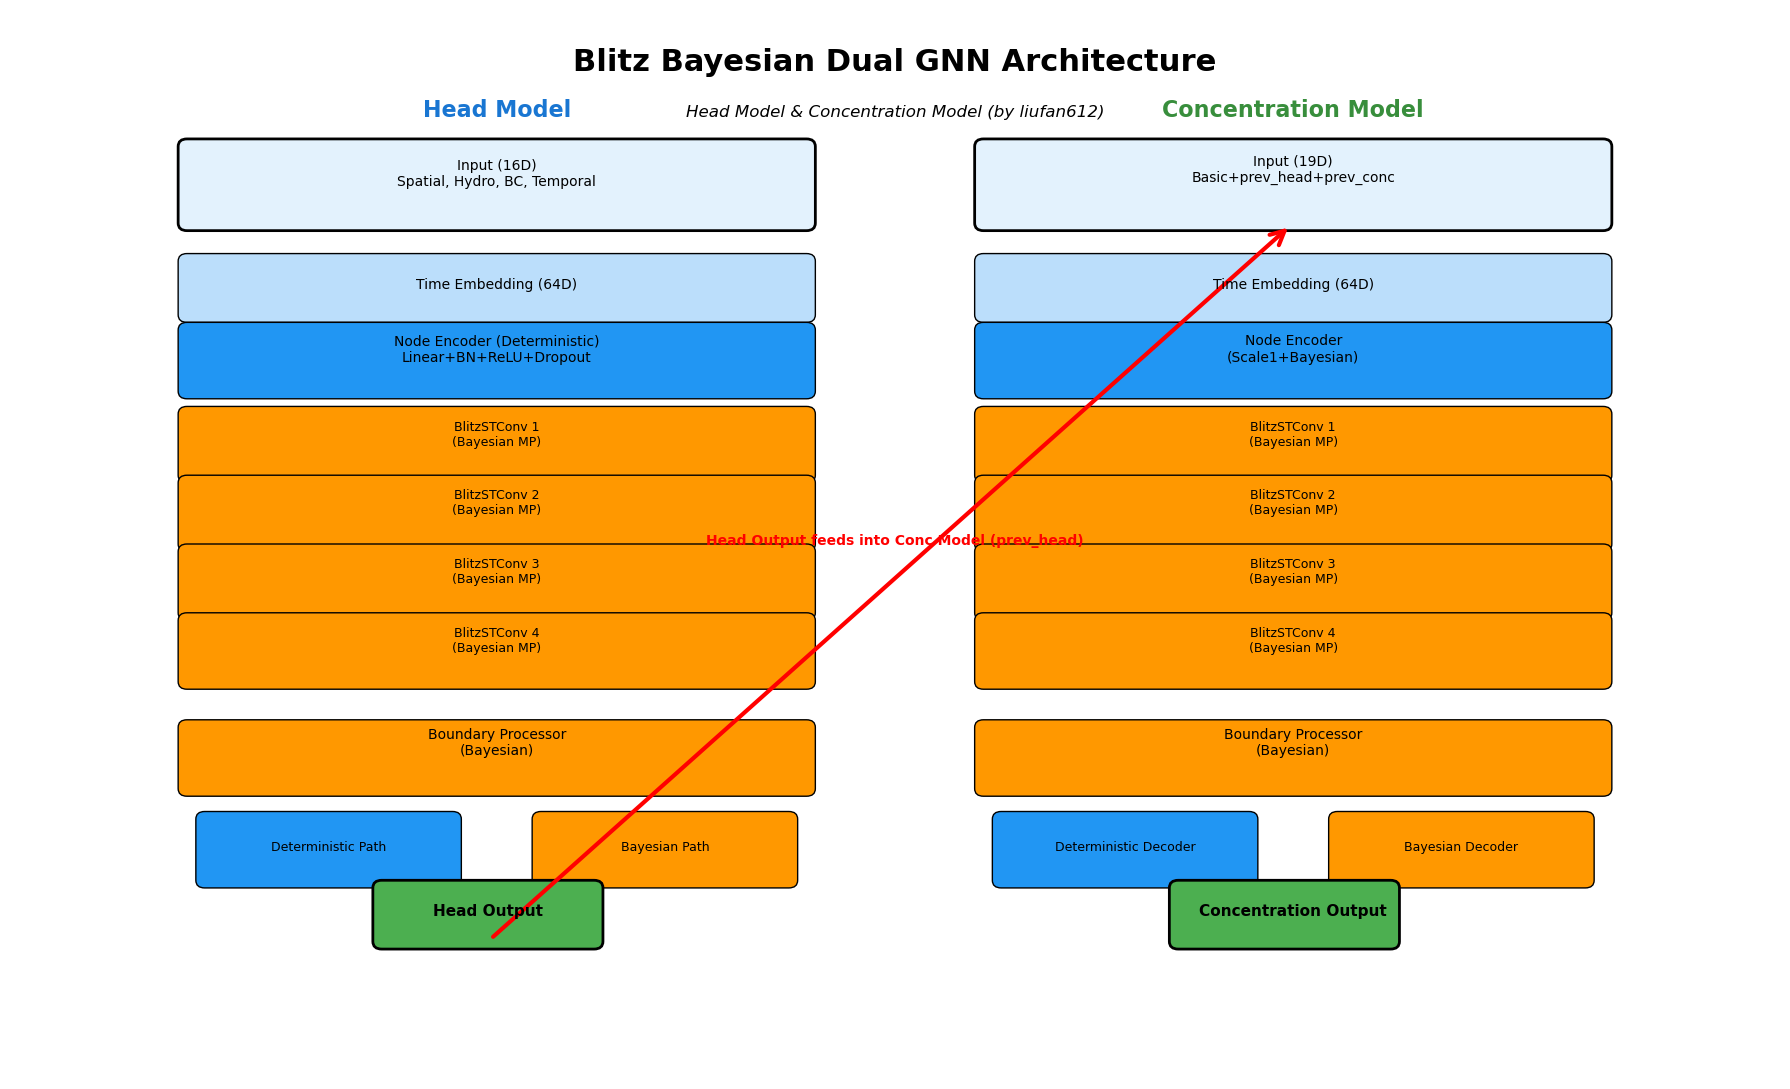

In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, ConnectionPatch

plt.figure(figsize=(18, 11))
ax = plt.gca()
ax.set_xlim(0, 20)
ax.set_ylim(0, 14)
ax.axis('off')

# 颜色定义
colors = {
    'input': '#E3F2FD',
    'embedding': '#BBDEFB', 
    'bayesian': '#FF9800',
    'deterministic': '#2196F3',
    'output': '#4CAF50',
    'connection': '#757575'
}

# 标题
ax.text(10, 13.2, 'Blitz Bayesian Dual GNN Architecture', fontsize=22, fontweight='bold', ha='center')
ax.text(10, 12.6, 'Head Model & Concentration Model (by liufan612)', fontsize=12, ha='center', style='italic')

# HEAD MODEL
x0, y0 = 2, 12
ax.text(x0+3.5, y0+0.6, 'Head Model', fontsize=16, fontweight='bold', ha='center', color='#1976D2')

# 输入特征
head_input = FancyBboxPatch((x0, y0-0.8), 7, 1, boxstyle="round,pad=0.1",
                           facecolor=colors['input'], edgecolor='black', linewidth=2)
ax.add_patch(head_input)
ax.text(x0+3.5, y0-0.3, 'Input (16D)\nSpatial, Hydro, BC, Temporal', fontsize=10, ha='center')

# 时间嵌入
head_time = FancyBboxPatch((x0, y0-2.0), 7, 0.7, boxstyle="round,pad=0.1",
                          facecolor=colors['embedding'], edgecolor='black')
ax.add_patch(head_time)
ax.text(x0+3.5, y0-1.65, 'Time Embedding (64D)', fontsize=10, ha='center')

# 节点编码器
head_enc = FancyBboxPatch((x0, y0-3.0), 7, 0.8, boxstyle="round,pad=0.1",
                          facecolor=colors['deterministic'], edgecolor='black')
ax.add_patch(head_enc)
ax.text(x0+3.5, y0-2.6, 'Node Encoder (Deterministic)\nLinear+BN+ReLU+Dropout', fontsize=10, ha='center')

# 贝叶斯卷积层
for i in range(4):
    box = FancyBboxPatch((x0, y0-4.1-i*0.9), 7, 0.8, boxstyle="round,pad=0.1",
                         facecolor=colors['bayesian'], edgecolor='black')
    ax.add_patch(box)
    ax.text(x0+3.5, y0-3.7-i*0.9, f'BlitzSTConv {i+1}\n(Bayesian MP)', fontsize=9, ha='center')

# 边界处理
bc_box = FancyBboxPatch((x0, y0-8.2), 7, 0.8, boxstyle="round,pad=0.1",
                        facecolor=colors['bayesian'], edgecolor='black')
ax.add_patch(bc_box)
ax.text(x0+3.5, y0-7.75, 'Boundary Processor\n(Bayesian)', fontsize=10, ha='center')

# 双分支输出
det_box = FancyBboxPatch((x0+0.2, y0-9.4), 2.8, 0.8, boxstyle="round,pad=0.1",
                        facecolor=colors['deterministic'], edgecolor='black')
bayes_box = FancyBboxPatch((x0+4, y0-9.4), 2.8, 0.8, boxstyle="round,pad=0.1",
                        facecolor=colors['bayesian'], edgecolor='black')
ax.add_patch(det_box)
ax.add_patch(bayes_box)
ax.text(x0+1.6, y0-9.0, 'Deterministic Path', fontsize=9, ha='center')
ax.text(x0+5.4, y0-9.0, 'Bayesian Path', fontsize=9, ha='center')

# Head output
head_out = FancyBboxPatch((x0+2.2, y0-10.2), 2.4, 0.7, boxstyle="round,pad=0.1",
                          facecolor=colors['output'], edgecolor='black', linewidth=2)
ax.add_patch(head_out)
ax.text(x0+3.4, y0-9.85, 'Head Output', fontsize=11, ha='center', fontweight='bold')

# CONC MODEL
x1, y1 = 11, 12
ax.text(x1+3.5, y1+0.6, 'Concentration Model', fontsize=16, fontweight='bold', ha='center', color='#388E3C')

# 输入特征
conc_input = FancyBboxPatch((x1, y1-0.8), 7, 1, boxstyle="round,pad=0.1",
                           facecolor=colors['input'], edgecolor='black', linewidth=2)
ax.add_patch(conc_input)
ax.text(x1+3.5, y1-0.25, 'Input (19D)\nBasic+prev_head+prev_conc', fontsize=10, ha='center')

# 时间嵌入
conc_time = FancyBboxPatch((x1, y1-2.0), 7, 0.7, boxstyle="round,pad=0.1",
                          facecolor=colors['embedding'], edgecolor='black')
ax.add_patch(conc_time)
ax.text(x1+3.5, y1-1.65, 'Time Embedding (64D)', fontsize=10, ha='center')

# 节点编码器
conc_enc = FancyBboxPatch((x1, y1-3.0), 7, 0.8, boxstyle="round,pad=0.1",
                          facecolor=colors['deterministic'], edgecolor='black')
ax.add_patch(conc_enc)
ax.text(x1+3.5, y1-2.6, 'Node Encoder\n(Scale1+Bayesian)', fontsize=10, ha='center')

# 贝叶斯卷积层
for i in range(4):
    box = FancyBboxPatch((x1, y1-4.1-i*0.9), 7, 0.8, boxstyle="round,pad=0.1",
                         facecolor=colors['bayesian'], edgecolor='black')
    ax.add_patch(box)
    ax.text(x1+3.5, y1-3.7-i*0.9, f'BlitzSTConv {i+1}\n(Bayesian MP)', fontsize=9, ha='center')

# 边界处理
bc_box = FancyBboxPatch((x1, y1-8.2), 7, 0.8, boxstyle="round,pad=0.1",
                        facecolor=colors['bayesian'], edgecolor='black')
ax.add_patch(bc_box)
ax.text(x1+3.5, y1-7.75, 'Boundary Processor\n(Bayesian)', fontsize=10, ha='center')

# 双分支输出
det_box = FancyBboxPatch((x1+0.2, y1-9.4), 2.8, 0.8, boxstyle="round,pad=0.1",
                        facecolor=colors['deterministic'], edgecolor='black')
bayes_box = FancyBboxPatch((x1+4, y1-9.4), 2.8, 0.8, boxstyle="round,pad=0.1",
                        facecolor=colors['bayesian'], edgecolor='black')
ax.add_patch(det_box)
ax.add_patch(bayes_box)
ax.text(x1+1.6, y1-9.0, 'Deterministic Decoder', fontsize=9, ha='center')
ax.text(x1+5.4, y1-9.0, 'Bayesian Decoder', fontsize=9, ha='center')

# Conc output
conc_out = FancyBboxPatch((x1+2.2, y1-10.2), 2.4, 0.7, boxstyle="round,pad=0.1",
                          facecolor=colors['output'], edgecolor='black', linewidth=2)
ax.add_patch(conc_out)
ax.text(x1+3.5, y1-9.85, 'Concentration Output', fontsize=11, ha='center', fontweight='bold')

# Head到Conc的连接（级联）
arrow = ConnectionPatch((x0+3.4, y0-10.2), (x1+3.5, y1-0.8), "data", "data",
                        arrowstyle='->', shrinkA=5, shrinkB=5, mutation_scale=25, fc='red', ec='red', linewidth=3)
ax.add_patch(arrow)
ax.text(10, 7, 'Head Output feeds into Conc Model (prev_head)', fontsize=10, ha='center', color='red', fontweight='bold')

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"架构图已保存为 {save_path}")